# **Implementing Traditional ML Algorithms**
TO PREDICT STOCK PRICE MOVEMENT TRENDS:
- UPWARD
- DOWNWARD
- NO CHANGE

# **Libraries**

In [ ]:
!pip install yellowbrick

In [1]:
# Supress warning messages
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import numpy as np
import sys
#np.set_printoptions(threshold=sys.maxsize)

# Visualization
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline streamlines feature scaling technique and resulting estimator (steps) to avoid data leakage
from sklearn.pipeline import make_pipeline

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler #, StandardScaler

# Splitting train/test sets
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC #, LinearSVC
from xgboost import XGBClassifier

# Evaluation metrics: Comparing actual response values with predicted response values 
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer, roc_auc_score, roc_curve

# K-fold cross validation
from sklearn.model_selection import cross_val_score 

# Plot ROC AUC
from yellowbrick.classifier import ROCAUC

# Hyperparameter tuning & cross validation
from sklearn.model_selection import cross_val_score #, RandomizedSearchCV, GridSearchCV

# Hyperparameter tuning -> Reduces time complexity
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV #, HalvingGridSearchCV

C:\Users\Home\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# **Load Dataset**
From 1-Initial Code Jupyter Notebook

In [2]:
df = pd.read_csv('./Output/working_df.csv')

In [3]:
df.set_index('post_date',inplace=True)

In [5]:
df.head(5)

,engagement,close_value,volume,open_value,high_value,low_value,prev_close,return,price_class,len_modify_body,comp_clean,pos_clean,neg_clean,neu_clean
post_date,,,,,,,,,,,,,,
2019-01-01,3,101.57,33161320,101.29,102.4,100.44,101.57,0.0,0,28,0.5267,0.595,0.0,0.405
2019-01-01,153,101.57,33161320,101.29,102.4,100.44,101.57,0.0,0,75,0.9001,0.588,0.0,0.412
2019-01-01,3,101.57,33161320,101.29,102.4,100.44,101.57,0.0,0,83,0.9468,0.658,0.0,0.342
2019-01-01,4,101.57,33161320,101.29,102.4,100.44,101.57,0.0,0,44,0.6124,0.400,0.0,0.600
2019-01-01,2,101.57,33161320,101.29,102.4,100.44,101.57,0.0,0,83,0.9468,0.658,0.0,0.342


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30298 entries, 2019-01-01 to 2019-12-31
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   engagement       30298 non-null  int64  
 1   close_value      30298 non-null  float64
 2   volume           30298 non-null  int64  
 3   open_value       30298 non-null  float64
 4   high_value       30298 non-null  float64
 5   low_value        30298 non-null  float64
 6   prev_close       30298 non-null  float64
 7   return           30298 non-null  float64
 8   price_class      30298 non-null  int64  
 9   len_modify_body  30298 non-null  int64  
 10  comp_clean       30298 non-null  float64
 11  pos_clean        30298 non-null  float64
 12  neg_clean        30298 non-null  float64
 13  neu_clean        30298 non-null  float64
dtypes: float64(10), int64(4)
memory usage: 3.5+ MB


# **Functions**

In [4]:
target_label = ['Downward Trend', 'No Change', 'Upward Trend']

def classReport (y_test, prediction):
    '''
    prints the classification report of the three price classes
    '''
    cr = classification_report(y_test, prediction, target_names = target_label)
    print(cr)

def confusionMatrix (model, X1_test, y1_test):
    '''
    plots the confusion matrix of the three class stock price movement trend
    '''
    cm = plot_confusion_matrix(model, X1_test, y1_test, xticks_rotation='vertical', display_labels=target_label,  cmap="BuPu")
    plt.grid(False)
    return cm


def getAUCscore(model, X_test, y_test):
    '''
    prints auc score only
    '''
    y_score = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_score, multi_class='ovr') # ovr is one vs rest
    # class 1 vs class 2&3, class 2 vs class 1&3, class 3 vs class 1&2
    print('AUC score is: {:.3f}'.format(auc))

#https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html
def plotROC(model, X1_train, y1_train, X1_test, y1_test):
    '''
    plots the ROC curves
    '''
    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder=target_label)
    plt.grid(False)                                    
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X1_train, y1_train)
    visualizer.score(X1_test, y1_test)
    visualizer.show()
    return visualizer

#https://datascience.stackexchange.com/questions/57701/should-i-perform-cross-validation-only-on-the-training-set
def crossValidation (model, X_train, y_train):
    '''
    returns the average of 5 accuracy values as a result of 5 folds
    '''
    accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)  # cv changed from 10 to 5 due to some models taking a long time to run
    # do K- fold cross validation on our traing data and its sentimenst with 10 fold cross validation
    print('Mean Accuracy of 5-fold cross validation: {:.3f}'.format(accuracies.mean()))
    print('Accuracies of 5-fold cross validation: ', np.array_str(accuracies, precision=3, suppress_small=True))

# **Machine Learning Models**

In [5]:
# Variables for ML models:
#linear_svc_clf = LinearSVC()
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
svc_clf = SVC(probability=True) # to calculate AUC scores for SVC models
xgb_clf = XGBClassifier(objective='multi:softmax') # set for classification


# Feature scaling for when upper and lower boundaries are known but are not normally distributed
scaler = MinMaxScaler()

# Scoring method for hyperparameter tuning
# https://datascience.stackexchange.com/questions/85981/micro-average-vs-macro-average-for-class-imbalance
avg_parameter = 'macro' # due to macro attempts to label classes correctly rather than try to predict correctly

# Create custom metric for GridSearchCV
f1 = make_scorer(f1_score, average='macro')

# Random state generator fixed
random_num=123

# Number of iterations for RandomizedSearchCV
num_iterations = 60 
#With 60 iterations, 95% of the time, best 5% sets of parameters can be found regardless of grid size
#https://towardsdatascience.com/hyper-parameter-tuning-with-randomised-grid-search-54f865d27926

# **PART 1: Using Sentiment Variables to Predict Stock Price/Class Trend**
**Predictors:** Sentiment Features (Compound Score, Neutral Sentiment, Negative Sentiment, Positive Sentiment) <br>
**Predict:** Price Class

For code -> 'ws' = 'with sentiment'

In [6]:
# Independent Variables
X1 = df[['comp_clean', 'neu_clean', 'pos_clean', 'neg_clean']]

# Dependent Variable
y1 = df[['price_class']]

In [10]:
X1.head(5)

,comp_clean,neu_clean,pos_clean,neg_clean
post_date,,,,
2019-01-01,0.5267,0.405,0.595,0.0
2019-01-01,0.9001,0.412,0.588,0.0
2019-01-01,0.9468,0.342,0.658,0.0
2019-01-01,0.6124,0.600,0.400,0.0
2019-01-01,0.9468,0.342,0.658,0.0


In [11]:
y1.head(5)

,price_class
post_date,
2019-01-01,0
2019-01-01,0
2019-01-01,0
2019-01-01,0
2019-01-01,0


In [7]:
# Train-test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=random_num)

# Rows, Columns of each train and test sets
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((22723, 4), (7575, 4), (22723, 1), (7575, 1))

## **Decision Tree Classifier**
The first model explored is the DT classifier. This is one of the most simple and speedy models to run because it learns simple decision rules inferred from training data to predict the class. This algorithm constructs a tree like structure for classification where each leaf node is the outcome, each internal node is the feature and the branch is the decision rule. The default settings is used for the base model, including “GINI” which is the criterion used to measure quality of split until we are left as close as possible to pure leaf nodes (such as majority voting). It does not backtrack and change a previous split, so all the following split depends on the current one and therefore, it does not guarantee optimal splits. This is how it works very efficiently. Lastly, the DT classifier is fed into a 5-fold cross validator.

In [13]:
?DecisionTreeClassifier

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None
    The maximum depth of the tree. If None, then nodes are expanded until
    all leaves are pure or until al

### Base Model (default settings)

In [14]:
# Running with default settings (hyperparameter and parameter values)

# Pipeline created with feature scaler and ML model
ws_dt_clf_pipe = make_pipeline(scaler, dt_clf)

# Fitting the training data
ws_dt_clf_pipe.fit(X1_train,y1_train) 

# Running time of data fitting
%time ws_dt_clf_pipe.fit(X1_train, y1_train)

# 5-fold cross validation of training data
# Divides data into 5 folds or equalish parts
# Trains each combination of 4
# Evalutes or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (ws_dt_clf_pipe, X1_train, y1_train)

Wall time: 52.8 ms
Mean Accuracy of 5-fold cross validation: 0.394
Accuracies of 5-fold cross validation:  [0.407 0.395 0.383 0.397 0.387]
Wall time: 229 ms


In [15]:
# Using model to predict test set
pred_dt_ws_model = ws_dt_clf_pipe.predict(X1_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\tDecision Tree Classifier - Classification Report \n===========================================================')
classReport(y1_test, pred_dt_ws_model)

	Decision Tree Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.26      0.15      0.19      1565
     No Change       0.42      0.62      0.50      3144
  Upward Trend       0.39      0.27      0.32      2866

      accuracy                           0.39      7575
     macro avg       0.36      0.35      0.34      7575
  weighted avg       0.38      0.39      0.37      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


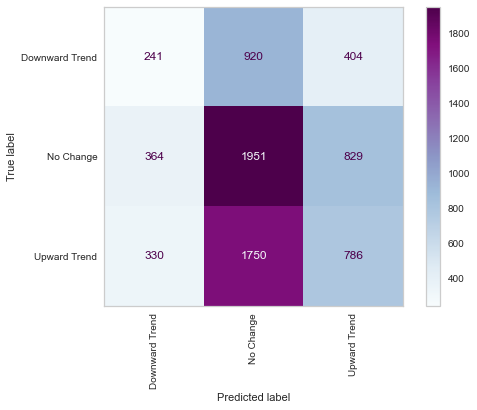

In [16]:
# Confusion Matrix - summary of the model's performance
ws_dt_cm = confusionMatrix(ws_dt_clf_pipe, X1_test, y1_test)

In [17]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(ws_dt_clf_pipe, X1_test, y1_test)

AUC score is: 0.514


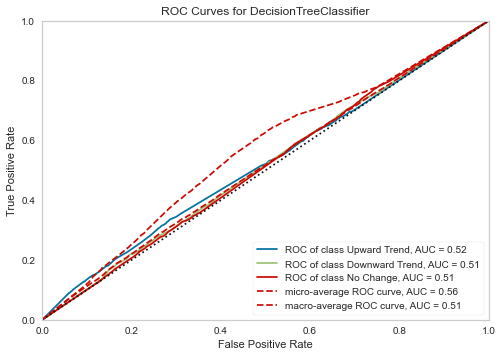

In [18]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
ws_dt_roc = plotROC(ws_dt_clf_pipe, X1_train, y1_train, X1_test, y1_test)

### Hyperparameter Tuning with HalvingRandomSearchCV
- Cross validation is performed during training (where cv = k-fold cross-validation)

In [19]:
# Find all parameters/hyperparameters of ws_dt_clf_pipe model
ws_dt_clf_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'decisiontreeclassifier', 'minmaxscaler__clip', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__random_state', 'decisiontreeclassifier__splitter'])

In [20]:
# Candidates for fitting
dt_parameters = {'decisiontreeclassifier__max_depth': np.arange(start=3, stop=1000, step=1), }

# using 5-fold cross validation
ws_dt_clf_grid = HalvingRandomSearchCV(estimator = ws_dt_clf_pipe, param_distributions = dt_parameters, n_jobs = -1, cv = 5, verbose = 2, scoring = f1,
                                    random_state=random_num)

In [21]:
# Conducting Random Search
%time ws_dt_clf_grid.fit(X1_train,y1_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 30
max_resources_: 22723
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 757
n_resources: 30
Fitting 5 folds for each of 757 candidates, totalling 3785 fits
----------
iter: 1
n_candidates: 253
n_resources: 90
Fitting 5 folds for each of 253 candidates, totalling 1265 fits
----------
iter: 2
n_candidates: 85
n_resources: 270
Fitting 5 folds for each of 85 candidates, totalling 425 fits
----------
iter: 3
n_candidates: 29
n_resources: 810
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 2430
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 5
n_candidates: 4
n_resources: 7290
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 6
n_candidates: 2
n_resources: 21870
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 10.4 s


HalvingRandomSearchCV(estimator=Pipeline(steps=[('minmaxscaler',
                                                 MinMaxScaler()),
                                                ('decisiontreeclassifier',
                                                 DecisionTreeClassifier())]),
                      n_jobs=-1,
                      param_distributions={'decisiontreeclassifier__max_depth': array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52...
       926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938,
       939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951,
       952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964,
       965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977,
       978, 979, 980, 981, 982, 983

In [22]:
# Returns the best combination from the list of combinations that were randomly checked
ws_dt_best_parameters = ws_dt_clf_grid.best_estimator_.get_params()
for param_name in sorted(dt_parameters.keys()):
    print('\t Optimal %s: %r' % (param_name, ws_dt_best_parameters[param_name]))

	 Optimal decisiontreeclassifier__max_depth: 859


In [23]:
# Looking for the best model results 
ws_dt_results = pd.DataFrame(ws_dt_clf_grid.cv_results_)
ws_dt_results.sort_values('rank_test_score')

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__max_depth,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
108,0,30,0.003788,0.000399,0.001794,7.458177e-04,175,{'decisiontreeclassifier__max_depth': 175},0.828571,0.583333,...,0.493492,0.284540,1,0.902381,0.90247,0.966583,0.964519,0.841461,0.915483,0.046553
422,0,30,0.003389,0.000488,0.001794,3.985643e-04,104,{'decisiontreeclassifier__max_depth': 104},0.828571,0.583333,...,0.493492,0.284540,1,0.902381,0.90247,0.966583,0.964519,0.841461,0.915483,0.046553
748,0,30,0.004186,0.000399,0.001196,3.985167e-04,210,{'decisiontreeclassifier__max_depth': 210},0.828571,0.583333,...,0.493492,0.284540,1,0.902381,0.90247,0.966583,0.964519,0.841461,0.915483,0.046553
479,0,30,0.004186,0.000976,0.001595,4.883830e-04,644,{'decisiontreeclassifier__max_depth': 644},0.828571,0.583333,...,0.493492,0.284540,1,0.902381,0.90247,0.966583,0.964519,0.841461,0.915483,0.046553
390,0,30,0.003190,0.000399,0.001993,5.917394e-07,775,{'decisiontreeclassifier__max_depth': 775},0.828571,0.583333,...,0.493492,0.284540,1,0.902381,0.90247,0.966583,0.964519,0.841461,0.915483,0.046553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0,30,0.003189,0.000399,0.001993,1.784161e-07,714,{'decisiontreeclassifier__max_depth': 714},0.244444,0.388889,...,0.264444,0.143226,1136,0.902381,0.90247,0.966583,0.964519,0.841461,0.915483,0.046553
314,0,30,0.003588,0.000489,0.001595,4.885194e-04,135,{'decisiontreeclassifier__max_depth': 135},0.244444,0.388889,...,0.264444,0.143226,1136,0.902381,0.90247,0.966583,0.964519,0.841461,0.915483,0.046553
500,0,30,0.003588,0.001196,0.001794,3.986120e-04,279,{'decisiontreeclassifier__max_depth': 279},0.244444,0.388889,...,0.264444,0.143226,1136,0.902381,0.90247,0.966583,0.964519,0.841461,0.915483,0.046553
688,0,30,0.004585,0.002238,0.001794,3.984928e-04,980,{'decisiontreeclassifier__max_depth': 980},0.244444,0.388889,...,0.264444,0.143226,1136,0.902381,0.90247,0.966583,0.964519,0.841461,0.915483,0.046553


In [24]:
# Running model with the optimal combination from hyperparameter tuning
dt_clf2 = DecisionTreeClassifier(max_depth=859)

# Pipeline created with feature scaler and ML model
ws_dt_clf_pipe_optimal = make_pipeline(scaler, dt_clf2)

# Fitting the training data
ws_dt_clf_pipe_optimal.fit(X1_train, y1_train)
%time ws_dt_clf_pipe_optimal.fit(X1_train, y1_train)

# Evalutes or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (ws_dt_clf_pipe_optimal, X1_train, y1_train)

Wall time: 57.8 ms
Mean Accuracy of 5-fold cross validation: 0.395
Accuracies of 5-fold cross validation:  [0.406 0.397 0.386 0.394 0.39 ]
Wall time: 234 ms


In [25]:
# Using model to predict test set
pred_dt_ws_model_optimal = ws_dt_clf_pipe_optimal.predict(X1_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\tDecision Tree Classifier - Classification Report \n===========================================================')
classReport(y1_test, pred_dt_ws_model_optimal)

	Decision Tree Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.25      0.15      0.19      1565
     No Change       0.42      0.62      0.50      3144
  Upward Trend       0.39      0.27      0.32      2866

      accuracy                           0.39      7575
     macro avg       0.36      0.35      0.34      7575
  weighted avg       0.38      0.39      0.37      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


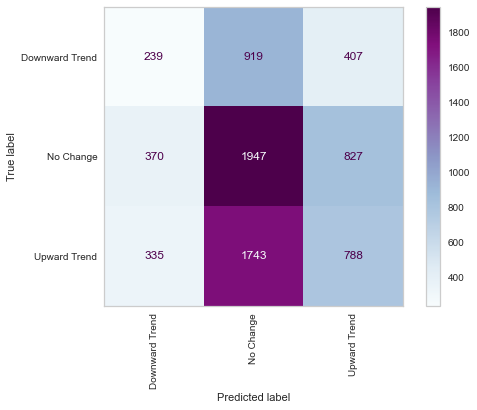

In [26]:
# Confusion Matrix - summary of the model's performance
pred_dt_ws_model_optimal = confusionMatrix(ws_dt_clf_pipe_optimal, X1_test, y1_test)

In [27]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(ws_dt_clf_pipe_optimal, X1_test, y1_test)

AUC score is: 0.513


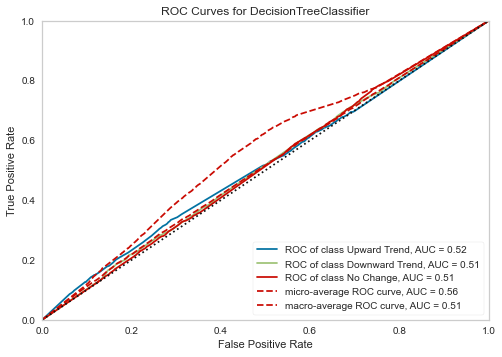

In [28]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
ws_dt_roc_optimal = plotROC(ws_dt_clf_pipe_optimal, X1_train, y1_train, X1_test, y1_test)

## **Random Forest Classifier**
RF classifier is an ensemble supervised machine learning algorithm, which is consists of large number of small decision trees (known as forest) and each tree generates its own class prediction (one tree has one vote). The class prediction with the most votes becomes the output of this model. This process improves test accuracy while reducing costs associated with storing training and getting inference from multiple models. The key idea is that there is wisdom in crowds insight drawn from a large group of models is likely to be more accurate than the prediction from any one model alone. A large group of uncorrelated trees working together in an ensemble will outperform just one individual tree. The forest is shielded from the errors of the individual trees by ensuring uncorrelatedness (via bootstrapping and feature randomness). Feature randomness refers to limiting the number of features each tree considers splitting to encourage diverse trees. Bootstrapping is creating smaller dataset (with replacement, some observations may be repeated) out of the training dataset through random sampling.

In [29]:
?rf_clf

Type:        RandomForestClassifier
String form: RandomForestClassifier()
File:        c:\users\home\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py
Docstring:  
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.

    .. versionchanged:: 0.22
       The default value of ``n_estimators`` changed from 10 to 100
       in 0.22.

criterion : {"gini", "entropy"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information 

### Base Model (default settings)

In [30]:
# Running with default settings (hyperparameter and parameter values)

# Pipeline created with feature scaler and ML model
ws_rf_clf_pipe = make_pipeline(scaler, rf_clf)

# Fitting the training data
ws_rf_clf_pipe.fit(X1_train, y1_train)

# Running time of data fitting
%time ws_rf_clf_pipe.fit(X1_train, y1_train)

# 5-fold cross validation of training data
# Divides data into 5 folds or equalish parts
# Trains each combination of 4
# Evalutes or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (ws_rf_clf_pipe, X1_train, y1_train)

Wall time: 1.84 s
Mean Accuracy of 5-fold cross validation: 0.402
Accuracies of 5-fold cross validation:  [0.408 0.405 0.396 0.41  0.389]
Wall time: 8.06 s


In [31]:
# Using model to predict test set
pred_rf_ws_model = ws_rf_clf_pipe.predict(X1_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\tRandom Forest Classifier - Classification Report \n===========================================================')
classReport(y1_test, pred_rf_ws_model)

	Random Forest Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.25      0.09      0.14      1565
     No Change       0.42      0.64      0.51      3144
  Upward Trend       0.38      0.29      0.33      2866

      accuracy                           0.40      7575
     macro avg       0.35      0.34      0.33      7575
  weighted avg       0.37      0.40      0.37      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


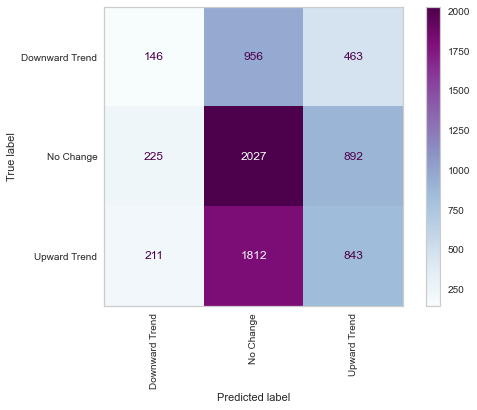

In [32]:
# Confusion Matrix - summary of the model's performance
ws_rf_cm = confusionMatrix(ws_rf_clf_pipe, X1_test, y1_test)

In [33]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(ws_rf_clf_pipe, X1_test, y1_test)

AUC score is: 0.517


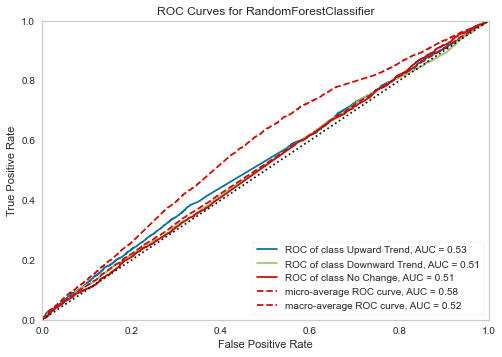

In [34]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
ws_rf_roc = plotROC(ws_rf_clf_pipe, X1_train, y1_train, X1_test, y1_test)

### Hyperparameter Tuning with HalvingRandomSearchCV
- Cross validation is performed during training (where cv = k-fold cross-validation)

In [35]:
# Find all parameters/hyperparameters of ws_rf_clf_pipe model
ws_rf_clf_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'randomforestclassifier', 'minmaxscaler__clip', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [36]:
# candidates for fitting
rf_parameters = {}
rf_parameters['randomforestclassifier__max_depth'] = np.arange(start=3, stop=1000, step=1) # same as DecisionTreeClassifier
rf_parameters['randomforestclassifier__n_estimators'] = np.arange(start=3, stop=1000, step=1)

# Using 5-fold cross validation
ws_rf_clf_grid = HalvingRandomSearchCV(estimator = ws_rf_clf_pipe, param_distributions = rf_parameters, n_jobs = -1, cv = 5, verbose = 2, scoring = f1,
                                    random_state=random_num)

In [37]:
# Conducting Random Search
%time ws_rf_clf_grid.fit(X1_train,y1_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 30
max_resources_: 22723
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 757
n_resources: 30
Fitting 5 folds for each of 757 candidates, totalling 3785 fits
----------
iter: 1
n_candidates: 253
n_resources: 90
Fitting 5 folds for each of 253 candidates, totalling 1265 fits
----------
iter: 2
n_candidates: 85
n_resources: 270
Fitting 5 folds for each of 85 candidates, totalling 425 fits
----------
iter: 3
n_candidates: 29
n_resources: 810
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 2430
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 5
n_candidates: 4
n_resources: 7290
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 6
n_candidates: 2
n_resources: 21870
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 18min 9s


HalvingRandomSearchCV(estimator=Pipeline(steps=[('minmaxscaler',
                                                 MinMaxScaler()),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier())]),
                      n_jobs=-1,
                      param_distributions={'randomforestclassifier__max_depth': array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52...
       926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938,
       939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951,
       952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964,
       965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977,
       978, 979, 980, 981, 982, 983

In [38]:
# Returns the best combination from the list of combinations that were randomly checked
ws_rf_best_parameters = ws_rf_clf_grid.best_estimator_.get_params()
for param_name in sorted(rf_parameters.keys()):
    print('\t Optimal %s: %r' % (param_name, ws_rf_best_parameters[param_name]))

	 Optimal randomforestclassifier__max_depth: 714
	 Optimal randomforestclassifier__n_estimators: 664


In [39]:
# Looking for the best model results 
ws_rf_results = pd.DataFrame(ws_rf_clf_grid.cv_results_)
ws_rf_results.sort_values('rank_test_score')

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
141,0,30,0.017342,0.001016,0.004385,0.001849,9,837,"{'randomforestclassifier__n_estimators': 9, 'r...",0.828571,...,0.552698,0.247856,1,0.867236,0.867725,0.966583,0.964519,0.841461,0.901505,0.053154
343,0,30,0.022923,0.003088,0.005183,0.000746,7,44,"{'randomforestclassifier__n_estimators': 7, 'r...",1.000000,...,0.548889,0.347946,2,0.902381,0.902470,0.932660,0.816416,0.841461,0.879078,0.043134
330,0,30,0.098470,0.030579,0.011163,0.004776,25,336,"{'randomforestclassifier__n_estimators': 25, '...",0.666667,...,0.546032,0.156041,3,0.902381,0.902470,0.966583,0.964519,0.827894,0.912770,0.050974
167,0,30,0.022326,0.011426,0.004585,0.001352,7,390,"{'randomforestclassifier__n_estimators': 7, 'r...",0.828571,...,0.527302,0.262853,4,0.841270,0.810224,0.897698,0.928030,0.735714,0.842587,0.067541
602,0,30,0.149899,0.011837,0.012956,0.000630,63,318,"{'randomforestclassifier__n_estimators': 63, '...",0.666667,...,0.492222,0.158293,5,0.902381,0.902470,0.966583,0.964519,0.827894,0.912770,0.050974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1,90,0.210496,0.030960,0.015349,0.000488,87,545,"{'randomforestclassifier__n_estimators': 87, '...",0.287179,...,0.284403,0.117797,1136,0.903434,0.881048,0.868604,0.874643,0.849627,0.875471,0.017486
765,1,90,0.668763,0.021208,0.051627,0.003177,297,518,"{'randomforestclassifier__n_estimators': 297, ...",0.320635,...,0.281480,0.116866,1137,0.903434,0.881048,0.870720,0.874643,0.849627,0.875894,0.017340
989,1,90,0.664976,0.033304,0.049833,0.002674,282,600,"{'randomforestclassifier__n_estimators': 282, ...",0.333333,...,0.280952,0.127322,1138,0.903434,0.881048,0.868604,0.873288,0.849627,0.875200,0.017507
879,1,90,0.411823,0.055925,0.042458,0.011954,126,130,"{'randomforestclassifier__n_estimators': 126, ...",0.323810,...,0.279933,0.141776,1139,0.903434,0.881048,0.868604,0.874643,0.849627,0.875471,0.017486


In [41]:
# Running model with the optimal combination from hyperparameter tuning
rf_clf2 = RandomForestClassifier(max_depth=714, n_estimators=664)

# Pipeline created with feature scaler and ML model
ws_rf_clf_pipe_optimal = make_pipeline(scaler, rf_clf2)

# Fitting the training data
ws_rf_clf_pipe_optimal.fit(X1_train,y1_train)
%time ws_rf_clf_pipe_optimal.fit(X1_train, y1_train)

# Evaluates or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (ws_rf_clf_pipe_optimal, X1_train, y1_train)

Wall time: 13.1 s
Mean Accuracy of 5-fold cross validation: 0.402
Accuracies of 5-fold cross validation:  [0.407 0.4   0.4   0.412 0.391]
Wall time: 1min


In [42]:
# Using model to predict test set
pred_rf_ws_model_optimal = ws_rf_clf_pipe_optimal.predict(X1_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\tRandom Forest Classifier - Classification Report \n===========================================================')
classReport(y1_test, pred_rf_ws_model_optimal)

	Random Forest Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.25      0.09      0.13      1565
     No Change       0.42      0.63      0.51      3144
  Upward Trend       0.39      0.31      0.35      2866

      accuracy                           0.40      7575
     macro avg       0.35      0.35      0.33      7575
  weighted avg       0.37      0.40      0.37      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


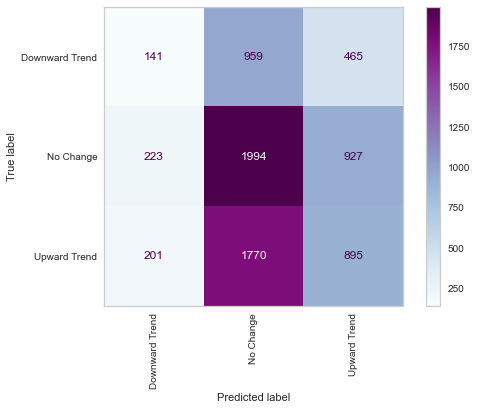

In [43]:
# Confusion Matrix - summary of the model's performance
ws_rf_cm_optimal = confusionMatrix(ws_rf_clf_pipe_optimal, X1_test, y1_test)

In [44]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(ws_rf_clf_pipe_optimal, X1_test, y1_test)

AUC score is: 0.517


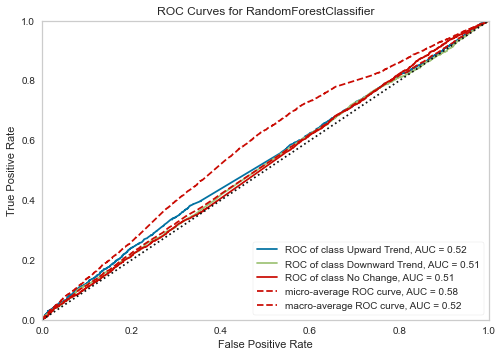

In [45]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
ws_rf_roc_optimal = plotROC(ws_rf_clf_pipe_optimal, X1_train, y1_train, X1_test, y1_test)

## **Extreme Gradient Boosting (XGBoost) Classifier**
The Extreme Gradient Boosting (XGBoost) classifier is a boosting supervised learning algorithm based on the gradient boosted decision trees, which is computationally efficient and often produces improved accuracy (XGBoost, n.d.). This model works by having multiple trees that build on top of each other to correct the errors of previously trained trees; in which the misclassified labels are given higher weights (XGBoost, n.d.). 

To control overfitting the data (high training accuracy but low test accuracy), the following parameters can be adjusted: maximum depth of tree and minimum child weight (XGBoost, n.d.). 

Another parameter that can be adjusted is the learning rate, which can impact the computational speed of running the algorithm on how fast the model learns. Learning rate adjusts the weights on each step of the training, where lower learning rate tends to produce better results but makes running the algorithm slower.


In [46]:
?xgb_clf

Type:        XGBClassifier
String form:
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
           colsample_byno <...>         subsample=None, tree_method=None, validate_parameters=None,
           verbosity=None)
File:        c:\users\home\anaconda3\lib\site-packages\xgboost\sklearn.py
Docstring:  
Implementation of the scikit-learn API for XGBoost classification.


Parameters
----------

    n_estimators : int
        Number of boosting rounds.
    use_label_encoder : bool
        (Deprecated) Use the label encoder from scikit-learn to encode the labels. For new
        code, we recommend that you set this parameter to False.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[int]
        The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    objective : typing.Union[str, typing.Callable[[numpy.ndarray, numpy.ndarray

### Base Model (default settings)

In [47]:
# Running with default settings (hyperparameter and parameter values)

# Pipeline created with feature scaler and ML model
ws_xgb_clf_pipe = make_pipeline(scaler, xgb_clf)

# Fitting the training data
ws_xgb_clf_pipe.fit(X1_train, y1_train)

# Running time of data fitting
%time ws_xgb_clf_pipe.fit(X1_train, y1_train)

# 5-fold cross validation of training data
# Divides data into 5 folds or equalish parts
# Trains each combination of 4
# Evalutes or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (ws_xgb_clf_pipe, X1_train, y1_train)

[07:02:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:03:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1.08 s
[07:03:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:03:02] WARNING: C:/Users/Administrator/worksp

In [48]:
# Using model to predict test set
pred_xgb_ws_model = ws_xgb_clf_pipe.predict(X1_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\tXGBoost Classifier - Classification Report \n===========================================================')
classReport(y1_test, pred_xgb_ws_model)

	XGBoost Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.26      0.04      0.07      1565
     No Change       0.41      0.73      0.53      3144
  Upward Trend       0.38      0.24      0.29      2866

      accuracy                           0.40      7575
     macro avg       0.35      0.34      0.30      7575
  weighted avg       0.37      0.40      0.34      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


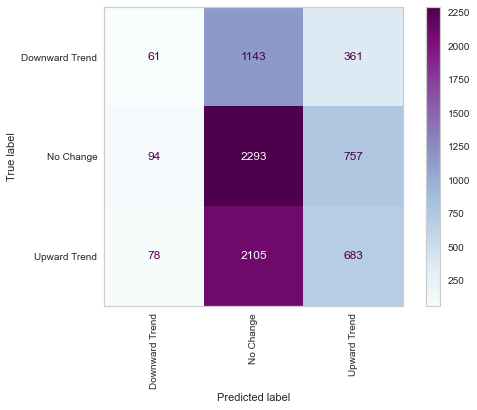

In [49]:
# Confusion Matrix - summary of the model's performance
ws_xgb_cm = confusionMatrix(ws_xgb_clf_pipe, X1_test, y1_test)

In [50]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(ws_xgb_clf_pipe, X1_test, y1_test)

AUC score is: 0.509


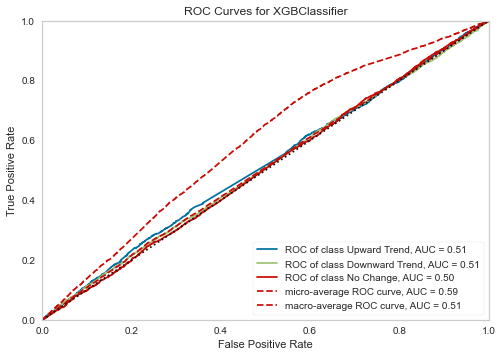

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder=['Downward Trend', 'No Change', 'Upward Trend'],
       estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('xgbclassifier',
                                  XGBClassifier(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=...
                                                interaction_constraints='',
                                                learning_rate=0.300000012,
                                                max_delta_step=0, max_depth=6,
                                                min_child_weight=1, missing=nan,
                                       

In [51]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
ws_xgb_roc= plotROC(ws_xgb_clf_pipe, X1_train, y1_train, X1_test, y1_test)
ws_xgb_roc

### Hyperparameter Tuning with HalvingRandomSearchCV
- Cross validation is performed during training (where cv = k-fold cross-validation)

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [52]:
# Find all parameters/hyperparameters of ws_xgb_clf_pipe model
ws_xgb_clf_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'xgbclassifier', 'minmaxscaler__clip', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'xgbclassifier__objective', 'xgbclassifier__use_label_encoder', 'xgbclassifier__base_score', 'xgbclassifier__booster', 'xgbclassifier__colsample_bylevel', 'xgbclassifier__colsample_bynode', 'xgbclassifier__colsample_bytree', 'xgbclassifier__enable_categorical', 'xgbclassifier__gamma', 'xgbclassifier__gpu_id', 'xgbclassifier__importance_type', 'xgbclassifier__interaction_constraints', 'xgbclassifier__learning_rate', 'xgbclassifier__max_delta_step', 'xgbclassifier__max_depth', 'xgbclassifier__min_child_weight', 'xgbclassifier__missing', 'xgbclassifier__monotone_constraints', 'xgbclassifier__n_estimators', 'xgbclassifier__n_jobs', 'xgbclassifier__num_parallel_tree', 'xgbclassifier__predictor', 'xgbclassifier__random_state', 'xgbclassifier__reg_alpha', 'xgbclassifier__reg_lambda', 'xgbclassifier__scale_pos_weight', 'xgbclassifier__subsample', 

In [53]:
# Candidates for fitting
xgb_parameters = {}
xgb_parameters['xgbclassifier__learning_rate'] = np.arange(start=0.0001, stop=3.0, step=0.0001) # regularization to reduce complexity
xgb_parameters['xgbclassifier__max_depth'] = np.arange(start=2, stop=6, step=1)
xgb_parameters['xgbclassifier__n_estimators'] = np.arange(start=10, stop=1000, step=10)
xgb_parameters['xgbclassifier__min_child_weight'] = np.arange(start=1, stop=20, step=1) # smaller for highly imbalanced class problems

# Using 5-fold cross validation
ws_xgb_clf_grid = HalvingRandomSearchCV(estimator = ws_xgb_clf_pipe, param_distributions = xgb_parameters, n_jobs = -1, cv = 5, verbose = 2, scoring = f1,
                                    random_state=random_num)

In [54]:
# This takes almost half an hour!!
# Conducting Random Search
%time ws_xgb_clf_grid.fit(X1_train,y1_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 30
max_resources_: 22723
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 757
n_resources: 30
Fitting 5 folds for each of 757 candidates, totalling 3785 fits
----------
iter: 1
n_candidates: 253
n_resources: 90
Fitting 5 folds for each of 253 candidates, totalling 1265 fits
----------
iter: 2
n_candidates: 85
n_resources: 270
Fitting 5 folds for each of 85 candidates, totalling 425 fits
----------
iter: 3
n_candidates: 29
n_resources: 810
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 2430
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 5
n_candidates: 4
n_resources: 7290
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 6
n_candidates: 2
n_resources: 21870
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[07:24:56] WARNING: C:/Users/Administrator/work

HalvingRandomSearchCV(estimator=Pipeline(steps=[('minmaxscaler',
                                                 MinMaxScaler()),
                                                ('xgbclassifier',
                                                 XGBClassifier(base_score=0.5,
                                                               booster='gbtree',
                                                               colsample_bylevel=1,
                                                               colsample_bynode=1,
                                                               colsample_bytree=1,
                                                               enable_categorical=False,
                                                               gamma=0,
                                                               gpu_id=-1,
                                                               importance_type=None,
                                                               interactio

In [55]:
# Returns the best combination from the list of combinations that were randomly checked
ws_xgb_best_parameters = ws_xgb_clf_grid.best_estimator_.get_params()
for param_name in sorted(xgb_parameters.keys()):
    print('\t Optimal %s: %r' % (param_name, ws_xgb_best_parameters[param_name]))

	 Optimal xgbclassifier__learning_rate: 2.0095000000000005
	 Optimal xgbclassifier__max_depth: 4
	 Optimal xgbclassifier__min_child_weight: 2
	 Optimal xgbclassifier__n_estimators: 770


In [56]:
# Looking for the best model results 
ws_xgb_results = pd.DataFrame(ws_xgb_clf_grid.cv_results_)
ws_xgb_results.sort_values('rank_test_score')

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__n_estimators,param_xgbclassifier__min_child_weight,param_xgbclassifier__max_depth,param_xgbclassifier__learning_rate,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
155,0,30,2.271003,0.028166,0.007774,3.989699e-04,770,2,4,2.4311,...,0.561905,0.244597,1,0.902381,0.902470,0.966583,0.929630,0.827894,0.905792,0.045507
79,0,30,1.593868,0.111954,0.006180,3.986359e-04,590,2,5,2.477,...,0.561905,0.244597,1,0.902381,0.902470,0.966583,0.964519,0.827894,0.912770,0.050974
7,0,30,0.287837,0.082162,0.005183,3.986598e-04,100,3,2,1.825,...,0.544127,0.247624,3,0.902381,0.867725,0.885486,0.843665,0.827894,0.865430,0.027039
412,0,30,0.491954,0.037129,0.007375,7.972479e-04,120,2,5,2.1824,...,0.529524,0.216222,4,0.902381,0.902470,0.966583,0.929630,0.827894,0.905792,0.045507
338,0,30,0.788562,0.041247,0.006777,3.985431e-04,230,2,2,0.1181,...,0.526349,0.192229,5,0.902381,0.902470,0.966583,0.916756,0.827894,0.903217,0.044437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,0,30,0.846369,0.058420,0.012359,8.111659e-03,330,13,3,0.9358,...,0.082540,0.041876,795,0.098765,0.098765,0.076923,0.114943,0.150538,0.107987,0.024470
486,0,30,0.623713,0.068762,0.007176,3.981118e-04,240,19,2,1.9229,...,0.082540,0.041876,795,0.098765,0.098765,0.076923,0.114943,0.150538,0.107987,0.024470
487,0,30,1.821307,0.068909,0.008172,1.464987e-03,670,13,4,1.0237,...,0.082540,0.041876,795,0.098765,0.098765,0.076923,0.114943,0.150538,0.107987,0.024470
474,0,30,0.250961,0.011698,0.007176,3.985882e-04,90,11,2,1.3574,...,0.082540,0.041876,795,0.098765,0.098765,0.076923,0.114943,0.150538,0.107987,0.024470


In [57]:
# Running model with the optimal combination from hyperparameter tuning
xgb_clf2 = XGBClassifier(objective='multi:softmax',
                        learning_rate=2.0095000000000005,
                        max_depth=4,
                        n_estimators=2,
                        min_child_weight=770)

# Pipeline created with feature scaler and ML model
ws_xgb_clf_pipe_optimal = make_pipeline(scaler, xgb_clf2)

# Fitting the training data
ws_xgb_clf_pipe_optimal.fit(X1_train, y1_train)
%time ws_xgb_clf_pipe_optimal.fit(X1_train, y1_train)

# Evaluates or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (ws_xgb_clf_pipe_optimal, X1_train, y1_train)

[07:25:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:25:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 29.9 ms
[07:25:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:25:59] WARNING: C:/Users/Administrator/works

In [58]:
# Using model to predict test set
pred_xgb_ws_model_optimal = ws_xgb_clf_pipe_optimal.predict(X1_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\tXGBoost Classifier - Classification Report \n===========================================================')
classReport(y1_test, pred_xgb_ws_model_optimal)

	XGBoost Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.00      0.00      0.00      1565
     No Change       0.42      0.77      0.54      3144
  Upward Trend       0.38      0.24      0.29      2866

      accuracy                           0.41      7575
     macro avg       0.27      0.33      0.28      7575
  weighted avg       0.32      0.41      0.33      7575



For downward stock price trend class, precision, recall and f1-score is 0. 
This means the classifier is labelling the instances into 2 classes: 'no change' or 'upward trend'. 

C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


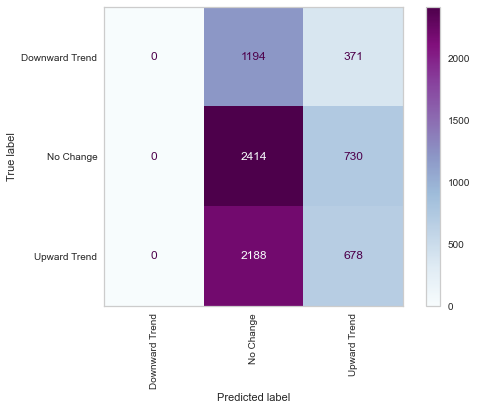

In [59]:
# Confusion Matrix - summary of the model's performance
ws_xgb_cm_optimal = confusionMatrix(ws_xgb_clf_pipe_optimal, X1_test, y1_test)

In [60]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(ws_xgb_clf_pipe_optimal, X1_test, y1_test)

AUC score is: 0.502


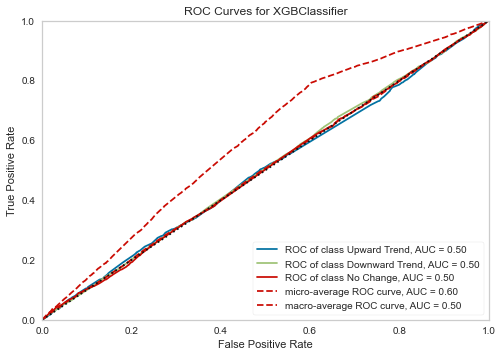

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder=['Downward Trend', 'No Change', 'Upward Trend'],
       estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('xgbclassifier',
                                  XGBClassifier(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=...
                                                interaction_constraints='',
                                                learning_rate=2.0095000000000005,
                                                max_delta_step=0, max_depth=4,
                                                min_child_weight=770,
                                           

In [61]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
ws_xgb_roc_optimal = plotROC(ws_xgb_clf_pipe_optimal, X1_train, y1_train, X1_test, y1_test)
ws_xgb_roc_optimal

## **Support Vector Classifier (SVC)**
Support vector machine is a distance-based supervised learning model that plots each data as a point in n-dimensional space in which one or more hyperplanes in hyperspace are constructed and find the optimal way to separate these points, the three data labels (widest separation means larger margin and lower classification error). However, lower classification error on training data does not always translate into lower misclassification on the testing data (and newer data points). In addition, support vector classifiers account for outliers through the regularization parameter, C, which penalizes misclassifications in the margin by a factor of C > 0. This means that the model must allow misclassification so that the model is not sensitive to outliers.

In [62]:
?svc_clf

Type:        SVC
String form: SVC(probability=True)
File:        c:\users\home\anaconda3\lib\site-packages\sklearn\svm\_classes.py
Docstring:  
C-Support Vector Classification.

The implementation is based on libsvm. The fit time scales at least
quadratically with the number of samples and may be impractical
beyond tens of thousands of samples. For large datasets
consider using :class:`~sklearn.svm.LinearSVC` or
:class:`~sklearn.linear_model.SGDClassifier` instead, possibly after a
:class:`~sklearn.kernel_approximation.Nystroem` transformer.

The multiclass support is handled according to a one-vs-one scheme.

For details on the precise mathematical formulation of the provided
kernel functions and how `gamma`, `coef0` and `degree` affect each
other, see the corresponding section in the narrative documentation:
:ref:`svm_kernels`.

Read more in the :ref:`User Guide <svm_classification>`.

Parameters
----------
C : float, default=1.0
    Regularization parameter. The strength of the regu

### Base Model (default settings)

In [63]:
# THIS IS TIME CONSUMING (~12 mins)
# Running with default settings (hyperparameter and parameter values)

# Pipeline created with feature scaler and ML model
ws_svc_clf_pipe = make_pipeline(scaler, svc_clf)

# Fitting the training data
ws_svc_clf_pipe.fit(X1_train, y1_train) 

# Running time of data fitting
%time ws_svc_clf_pipe.fit(X1_train, y1_train)

# 5-fold cross validation of training data
# Divides data into 5 folds or equalish parts
# Trains each combination of 4
# Evalutes or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (ws_svc_clf_pipe, X1_train, y1_train)

Wall time: 2min 24s
Mean Accuracy of 5-fold cross validation: 0.420
Accuracies of 5-fold cross validation:  [0.421 0.42  0.42  0.419 0.419]
Wall time: 7min 52s


In [64]:
# Using model to predict test set
pred_svc_ws_model = ws_svc_clf_pipe.predict(X1_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\tSupport Vector Classifier - Classification Report \n===========================================================')
classReport(y1_test, pred_svc_ws_model)

	Support Vector Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.00      0.00      0.00      1565
     No Change       0.42      1.00      0.59      3144
  Upward Trend       0.33      0.00      0.00      2866

      accuracy                           0.42      7575
     macro avg       0.25      0.33      0.20      7575
  weighted avg       0.30      0.42      0.24      7575



For downward stock price trend class, precision, recall and f1-score is 0. 
This means the classifier is labelling the instances into 2 classes: 'no change' or 'upward trend'. 

C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


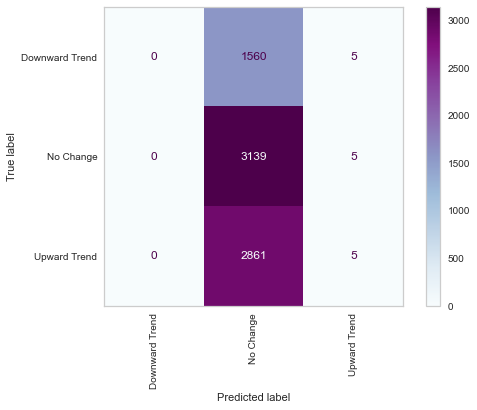

In [65]:
# Confusion Matrix - summary of the model's performance
ws_svc_cm = confusionMatrix(ws_svc_clf_pipe, X1_test, y1_test)

In [66]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(ws_svc_clf_pipe, X1_test, y1_test)

# Since default probability=False, this default setting was changed to True 
# (even though requires a lot of computational power). 

AUC score is: 0.493


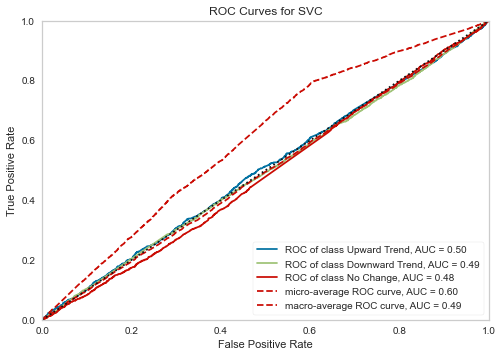

In [67]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
ws_svc_roc = plotROC(ws_svc_clf_pipe, X1_train, y1_train, X1_test, y1_test)

### Hyperparameter Tuning with HalvingRandomSearchCV
- Cross validation is performed during training (where cv = k-fold cross-validation)

In [68]:
# candidates for fitting
svc_parameters = {}
svc_parameters['svc__C'] = [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000] # regularization parameter
svc_parameters['svc__gamma'] = [0.0001, 0.001, 0.01, 0.1, 1, 50, 10, 100, 500, 1000] 

# using 5-fold cross validation
ws_svc_clf_grid = HalvingRandomSearchCV(estimator = ws_svc_clf_pipe, param_distributions = svc_parameters, n_jobs = -1, cv = 5, verbose = 2, scoring = f1,
                                    random_state=random_num)

In [69]:
# takes ~1 hour!
# Conducting Random Search
%time ws_svc_clf_grid.fit(X1_train,y1_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 7
min_resources_: 30
max_resources_: 22723
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 30
Fitting 5 folds for each of 100 candidates, totalling 500 fits
----------
iter: 1
n_candidates: 34
n_resources: 90
Fitting 5 folds for each of 34 candidates, totalling 170 fits
----------
iter: 2
n_candidates: 12
n_resources: 270
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 4
n_resources: 810
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 2430
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 7min 49s


HalvingRandomSearchCV(estimator=Pipeline(steps=[('minmaxscaler',
                                                 MinMaxScaler()),
                                                ('svc',
                                                 SVC(probability=True))]),
                      n_jobs=-1,
                      param_distributions={'svc__C': [0.0001, 0.001, 0.01, 0.1,
                                                      1, 10, 50, 100, 500,
                                                      1000],
                                           'svc__gamma': [0.0001, 0.001, 0.01,
                                                          0.1, 1, 50, 10, 100,
                                                          500, 1000]},
                      random_state=123,
                      scoring=make_scorer(f1_score, average=macro), verbose=2)

In [70]:
# Returns the best combination from the list of combinations that were randomly checked
ws_svc_best_parameters = ws_svc_clf_grid.best_estimator_.get_params()
for param_name in sorted(svc_parameters.keys()):
    print('\t Optimal %s: %r' % (param_name, ws_svc_best_parameters[param_name]))

	 Optimal svc__C: 50
	 Optimal svc__gamma: 100


In [71]:
# Looking for the best model results 
ws_svc_results = pd.DataFrame(ws_svc_clf_grid.cv_results_)
ws_svc_results.sort_values('rank_test_score')

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__gamma,param_svc__C,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
75,0,30,0.003588,0.000488,0.001595,0.000488,50,100,"{'svc__gamma': 50, 'svc__C': 100}",0.625000,...,0.497222,0.210731,1,0.902381,0.90247,0.966583,0.964519,0.827894,0.91277,0.050974
65,0,30,0.004186,0.000976,0.002990,0.001261,50,50,"{'svc__gamma': 50, 'svc__C': 50}",0.625000,...,0.497222,0.210731,1,0.902381,0.90247,0.966583,0.964519,0.827894,0.91277,0.050974
55,0,30,0.005980,0.003023,0.009368,0.014751,50,10,"{'svc__gamma': 50, 'svc__C': 10}",0.625000,...,0.497222,0.210731,1,0.902381,0.90247,0.966583,0.964519,0.827894,0.91277,0.050974
85,0,30,0.003192,0.000980,0.001392,0.000491,50,500,"{'svc__gamma': 50, 'svc__C': 500}",0.625000,...,0.497222,0.210731,1,0.902381,0.90247,0.966583,0.964519,0.827894,0.91277,0.050974
95,0,30,0.003190,0.001465,0.001594,0.000487,50,1000,"{'svc__gamma': 50, 'svc__C': 1000}",0.625000,...,0.497222,0.210731,1,0.902381,0.90247,0.966583,0.964519,0.827894,0.91277,0.050974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0,30,0.003787,0.000399,0.001794,0.000398,0.0001,1000,"{'svc__gamma': 0.0001, 'svc__C': 1000}",0.333333,...,0.231746,0.052740,100,0.215686,0.20202,0.215686,0.196078,0.196078,0.20511,0.008904
31,0,30,0.002990,0.000630,0.002194,0.000978,0.001,0.1,"{'svc__gamma': 0.001, 'svc__C': 0.1}",0.333333,...,0.231746,0.052740,100,0.215686,0.20202,0.215686,0.196078,0.196078,0.20511,0.008904
32,0,30,0.003389,0.000490,0.001793,0.000398,0.01,0.1,"{'svc__gamma': 0.01, 'svc__C': 0.1}",0.333333,...,0.231746,0.052740,100,0.215686,0.20202,0.215686,0.196078,0.196078,0.20511,0.008904
27,0,30,0.003189,0.000746,0.001794,0.000746,100,0.01,"{'svc__gamma': 100, 'svc__C': 0.01}",0.333333,...,0.231746,0.052740,100,0.215686,0.20202,0.215686,0.196078,0.196078,0.20511,0.008904


In [72]:
# Running model with the optimal combination from hyperparameter tuning

# ~8mins to run
# using 5-fold cross validation
svc_clf2 = SVC(probability=True, C = 50, gamma = 100)

# Pipeline created with feature scaler and ML model
ws_svc_clf_pipe_optimal = make_pipeline(scaler, svc_clf2)

# Fitting the training data
ws_svc_clf_pipe_optimal.fit(X1_train, y1_train)
%time ws_svc_clf_pipe_optimal.fit(X1_train, y1_train)

# Evaluates or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (ws_svc_clf_pipe_optimal, X1_train, y1_train)

Wall time: 7min 17s
Mean Accuracy of 5-fold cross validation: 0.414
Accuracies of 5-fold cross validation:  [0.417 0.411 0.414 0.417 0.413]
Wall time: 22min 11s


In [73]:
# Using model to predict test set
pred_svc_ws_model_optimal = ws_svc_clf_pipe_optimal.predict(X1_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\tSupport Vector Classifier - Classification Report \n===========================================================')
classReport(y1_test, pred_svc_ws_model_optimal)

	Support Vector Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.25      0.03      0.05      1565
     No Change       0.41      0.70      0.52      3144
  Upward Trend       0.38      0.28      0.32      2866

      accuracy                           0.40      7575
     macro avg       0.35      0.33      0.29      7575
  weighted avg       0.37      0.40      0.35      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


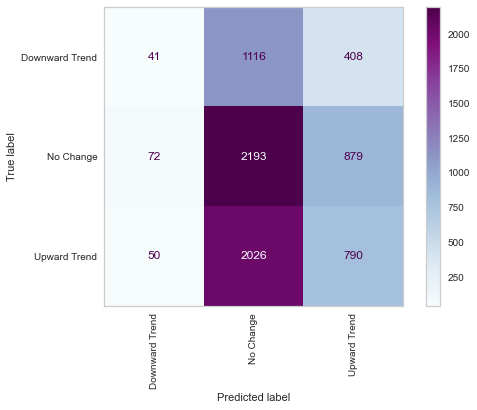

In [74]:
# Confusion Matrix - summary of the model's performance
ws_svc_cm_optimal = confusionMatrix(ws_svc_clf_pipe_optimal, X1_test, y1_test)

In [75]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(ws_svc_clf_pipe_optimal, X1_test, y1_test)

AUC score is: 0.503


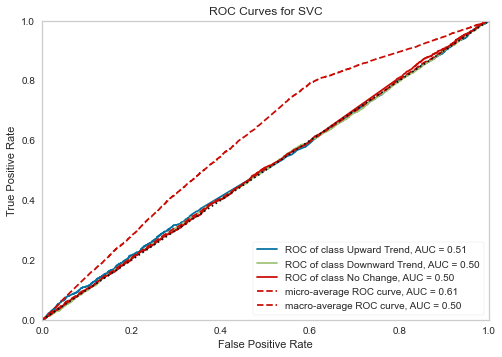

In [76]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
ws_svc_roc_optimal = plotROC(ws_svc_clf_pipe_optimal, X1_train, y1_train, X1_test, y1_test)

# **PART 2: Using Volume and Return to Predict Stock Price Class/Trend**
**Predictors:** Volume<br>
**Predict:** Price Class

For code -> 'wos' = 'without sentiment'

In [8]:
# Independent Variables based on the feature importance methods and Pearson correlation
X2 = np.array(df[['volume']]) # return feature excluded due to results in 100% accuracy (maybe overfit?)

# Dependent Variable
y2 = np.array(df[['price_class']])

# Train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=random_num)

# Rows, Columns of each train and test sets
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((22723, 1), (7575, 1), (22723, 1), (7575, 1))

In [78]:
X2

array([[33161320],
       [33161320],
       [33161320],
       ...,
       [18393380],
       [18393380],
       [18393380]], dtype=int64)

In [79]:
y2

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [-1],
       [-1],
       [-1]], dtype=int64)

## **Decision Tree Classifier**
The first model explored is the DT classifier. This is one of the most simple and speedy models to run because it learns simple decision rules inferred from training data to predict the class. This algorithm constructs a tree like structure for classification where each leaf node is the outcome, each internal node is the feature and the branch is the decision rule. The default settings is used for the base model, including “GINI” which is the criterion used to measure quality of split until we are left as close as possible to pure leaf nodes (such as majority voting). It does not backtrack and change a previous split, so all the following split depends on the current one and therefore, it does not guarantee optimal splits. This is how it works very efficiently. Lastly, the DT classifier is fed into a 5-fold cross validator.

### Base Model (default settings)

In [10]:
# Running with default settings (hyperparameter and parameter values)

# Pipeline created with feature scaler and ML model
wos_dt_clf_pipe = make_pipeline(scaler, dt_clf)

# Fitting the training data
wos_dt_clf_pipe.fit(X2_train,y2_train) 

# Running time of data fitting
%time wos_dt_clf_pipe.fit(X2_train, y2_train)

# 5-fold cross validation of training data
# Divides data into 5 folds or equalish parts
# Trains each combination of 4
# Evalutes or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (wos_dt_clf_pipe, X2_train, y2_train)

Wall time: 9.01 ms
Mean Accuracy of 5-fold cross validation: 0.913
Accuracies of 5-fold cross validation:  [0.916 0.917 0.914 0.912 0.905]
Wall time: 54.9 ms


In [81]:
# Using model to predict test set
pred_dt_wos_model = wos_dt_clf_pipe.predict(X2_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\tDecision Tree Classifier - Classification Report \n===========================================================')
classReport(y2_test, pred_dt_wos_model)

	Decision Tree Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.93      0.85      0.89      1565
     No Change       0.94      0.93      0.93      3144
  Upward Trend       0.89      0.94      0.91      2866

      accuracy                           0.92      7575
     macro avg       0.92      0.91      0.91      7575
  weighted avg       0.92      0.92      0.92      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


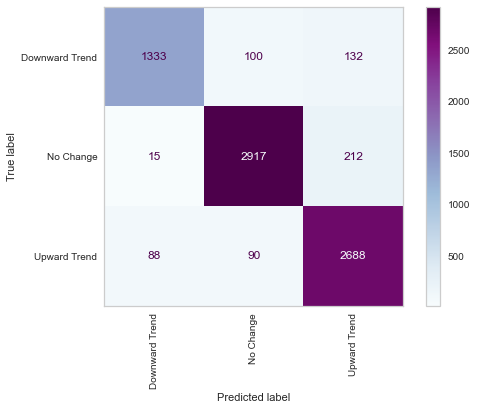

In [82]:
# Confusion Matrix - summary of the model's performance
wos_dt_cm = confusionMatrix(wos_dt_clf_pipe, X2_test, y2_test)

In [83]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(wos_dt_clf_pipe, X2_test, y2_test)

AUC score is: 0.991


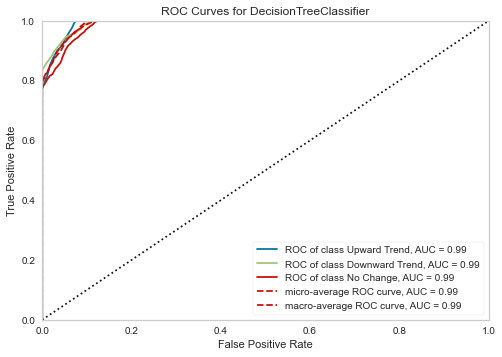

In [84]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
wos_dt_roc = plotROC(wos_dt_clf_pipe, X2_train, y2_train, X2_test, y2_test)

### Hyperparameter Tuning with HalvingRandomSearchCV
- Cross validation is performed during training (where cv = k-fold cross-validation)

In [85]:
# Find all parameters of wos_dt_clf_pipe model
wos_dt_clf_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'decisiontreeclassifier', 'minmaxscaler__clip', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__random_state', 'decisiontreeclassifier__splitter'])

In [86]:
# candidates for fitting
wos_dt_parameters = {'decisiontreeclassifier__max_depth': np.arange(start=3, stop=10, step=1), }
# Anything higher will overfit data (99% or more accuracy)

# Using 5-fold cross validation
wos_dt_clf_grid = HalvingRandomSearchCV(estimator = wos_dt_clf_pipe, param_distributions = dt_parameters, n_jobs = -1, cv = 5, verbose = 2, scoring = f1,
                                    random_state=random_num)
#wos_dt_parameters

In [87]:
# Conducting Random Search
%time wos_dt_clf_grid.fit(X2_train,y2_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 30
max_resources_: 22723
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 757
n_resources: 30
Fitting 5 folds for each of 757 candidates, totalling 3785 fits
----------
iter: 1
n_candidates: 253
n_resources: 90
Fitting 5 folds for each of 253 candidates, totalling 1265 fits
----------
iter: 2
n_candidates: 85
n_resources: 270
Fitting 5 folds for each of 85 candidates, totalling 425 fits
----------
iter: 3
n_candidates: 29
n_resources: 810
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 2430
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 5
n_candidates: 4
n_resources: 7290
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 6
n_candidates: 2
n_resources: 21870
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 4.82 s


HalvingRandomSearchCV(estimator=Pipeline(steps=[('minmaxscaler',
                                                 MinMaxScaler()),
                                                ('decisiontreeclassifier',
                                                 DecisionTreeClassifier())]),
                      n_jobs=-1,
                      param_distributions={'decisiontreeclassifier__max_depth': array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52...
       926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938,
       939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951,
       952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964,
       965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977,
       978, 979, 980, 981, 982, 983

In [88]:
# Returns the best combination from the list of combinations that were randomly checked
wos_dt_best_parameters = wos_dt_clf_grid.best_estimator_.get_params()
for param_name in sorted(wos_dt_parameters.keys()):
    print('\t Optimal %s: %r' % (param_name, wos_dt_best_parameters[param_name]))

	 Optimal decisiontreeclassifier__max_depth: 665


In [89]:
# Looking for the best model results 
wos_dt_results = pd.DataFrame(wos_dt_clf_grid.cv_results_)
wos_dt_results.sort_values('rank_test_score')

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__max_depth,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1139,6,21870,0.011561,4.881300e-04,0.002392,0.000488,763,{'decisiontreeclassifier__max_depth': 763},0.913622,0.913436,...,0.907646,0.005562,1,0.910978,0.910224,0.911911,0.911929,0.913444,0.911697,0.001081
1138,6,21870,0.011760,9.770969e-04,0.003189,0.001933,665,{'decisiontreeclassifier__max_depth': 665},0.913622,0.913436,...,0.907646,0.005562,1,0.910978,0.910224,0.911911,0.911929,0.913444,0.911697,0.001081
1136,5,7290,0.004385,4.887723e-04,0.001595,0.000488,665,{'decisiontreeclassifier__max_depth': 665},0.924127,0.911609,...,0.904144,0.013620,3,0.911607,0.911740,0.916057,0.913008,0.910024,0.912487,0.002020
1134,5,7290,0.003987,8.913237e-04,0.001595,0.000488,564,{'decisiontreeclassifier__max_depth': 564},0.924127,0.911609,...,0.904144,0.013620,3,0.911607,0.911740,0.916057,0.913008,0.910024,0.912487,0.002020
1137,5,7290,0.004585,4.880910e-04,0.001395,0.000488,763,{'decisiontreeclassifier__max_depth': 763},0.924127,0.911609,...,0.904144,0.013620,3,0.911607,0.911740,0.916057,0.913008,0.910024,0.912487,0.002020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,0,30,0.000797,3.986836e-04,0.000598,0.000488,736,{'decisiontreeclassifier__max_depth': 736},0.357143,0.655556,...,0.427302,0.119005,384,1.000000,0.945419,0.932773,1.000000,1.000000,0.975638,0.030103
380,0,30,0.000997,3.568323e-07,0.001594,0.001737,722,{'decisiontreeclassifier__max_depth': 722},0.357143,0.655556,...,0.427302,0.119005,384,1.000000,0.945419,0.932773,1.000000,1.000000,0.975638,0.030103
569,0,30,0.000797,3.986359e-04,0.000797,0.000399,803,{'decisiontreeclassifier__max_depth': 803},0.357143,0.655556,...,0.427302,0.119005,384,1.000000,0.945419,0.932773,1.000000,1.000000,0.975638,0.030103
663,0,30,0.000997,6.302233e-04,0.001196,0.000399,4,{'decisiontreeclassifier__max_depth': 4},0.488889,0.388889,...,0.420317,0.044765,1139,0.867236,0.795261,0.784512,0.828070,1.000000,0.855016,0.078022


In [9]:
# Running model with the optimal combination from hyperparameter tuning
dt_clf3 = DecisionTreeClassifier(max_depth=665)

# Pipeline created with feature scaler and ML model
wos_dt_clf_pipe_optimal = make_pipeline(scaler, dt_clf3)

# Fitting the training data
wos_dt_clf_pipe_optimal.fit(X2_train,y2_train)
%time wos_dt_clf_pipe_optimal.fit(X2_train, y2_train)

# Evaluates or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (wos_dt_clf_pipe_optimal, X2_train, y2_train)

Wall time: 11 ms
Mean Accuracy of 5-fold cross validation: 0.913
Accuracies of 5-fold cross validation:  [0.916 0.917 0.914 0.912 0.905]
Wall time: 51.8 ms


In [91]:
# Using model to predict test set
pred_dt_wos_model_optimal = wos_dt_clf_pipe_optimal.predict(X2_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\tDecision Tree Classifier - Classification Report \n===========================================================')
classReport(y2_test, pred_dt_wos_model_optimal)

	Decision Tree Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.93      0.85      0.89      1565
     No Change       0.94      0.93      0.93      3144
  Upward Trend       0.89      0.94      0.91      2866

      accuracy                           0.92      7575
     macro avg       0.92      0.91      0.91      7575
  weighted avg       0.92      0.92      0.92      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


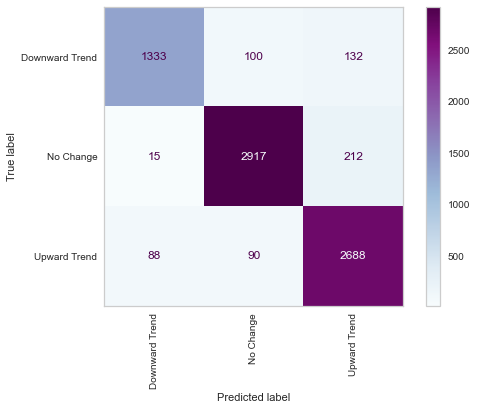

In [92]:
# Confusion Matrix - summary of the model's performance
wos_dt_cm_optimal = confusionMatrix(wos_dt_clf_pipe_optimal, X2_test, y2_test)

In [93]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(wos_dt_clf_pipe_optimal, X2_test, y2_test)

AUC score is: 0.991


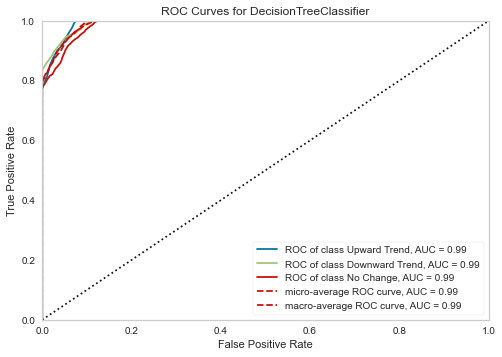

In [94]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
wos_dt_roc_optimal = plotROC(wos_dt_clf_pipe_optimal, X2_train, y2_train, X2_test, y2_test)

## **Random Forest Classifier**
RF classifier is an ensemble supervised machine learning algorithm, which is consists of large number of small decision trees (known as forest) and each tree generates its own class prediction (one tree has one vote). The class prediction with the most votes becomes the output of this model. This process improves test accuracy while reducing costs associated with storing training and getting inference from multiple models. The key idea is that there is wisdom in crowds insight drawn from a large group of models is likely to be more accurate than the prediction from any one model alone. A large group of uncorrelated trees working together in an ensemble will outperform just one individual tree. The forest is shielded from the errors of the individual trees by ensuring uncorrelatedness (via bootstrapping and feature randomness). Feature randomness refers to limiting the number of features each tree considers splitting to encourage diverse trees. Bootstrapping is creating smaller dataset (with replacement, some observations may be repeated) out of the training dataset through random sampling.

### Base Model (default settings)

In [11]:
# Running with default settings (hyperparameter and parameter values)

# Pipeline created with feature scaler and ML model
wos_rf_clf_pipe = make_pipeline(scaler, rf_clf)

# Fitting the training data
wos_rf_clf_pipe.fit(X2_train,y2_train) 

# Running time of data fitting
%time wos_rf_clf_pipe.fit(X2_train, y2_train)

# 5-fold cross validation of training data
# Divides data into 5 folds or equalish parts
# Trains each combination of 4
# Evalutes or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (wos_rf_clf_pipe, X2_train, y2_train)

Wall time: 913 ms
Mean Accuracy of 5-fold cross validation: 0.913
Accuracies of 5-fold cross validation:  [0.916 0.917 0.914 0.912 0.905]
Wall time: 4.26 s


In [96]:
# Using model to predict test set
pred_rf_wos_model = wos_rf_clf_pipe.predict(X2_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\tRandom Forest Classifier - Classification Report \n===========================================================')
classReport(y2_test, pred_rf_wos_model)

	Random Forest Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.93      0.84      0.88      1565
     No Change       0.94      0.93      0.93      3144
  Upward Trend       0.88      0.94      0.91      2866

      accuracy                           0.91      7575
     macro avg       0.92      0.90      0.91      7575
  weighted avg       0.92      0.91      0.91      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


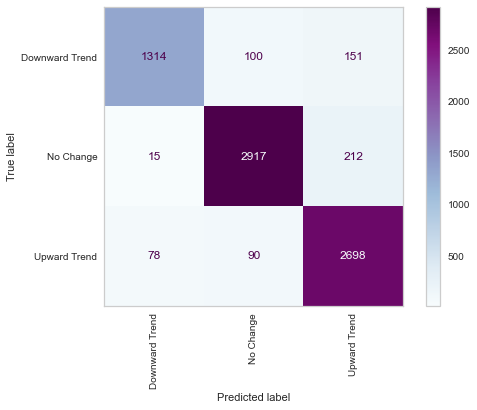

In [97]:
# Confusion Matrix - summary of the model's performance
wos_rf_cm = confusionMatrix(wos_rf_clf_pipe, X2_test, y2_test)

In [98]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(wos_rf_clf_pipe, X2_test, y2_test)

AUC score is: 0.991


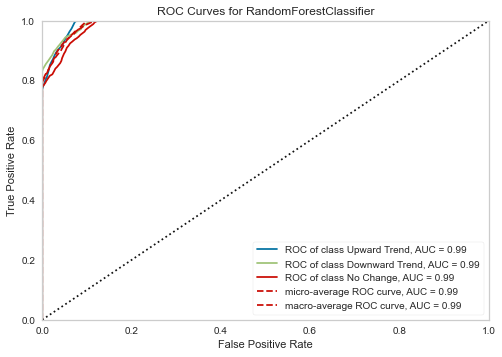

In [99]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
wos_rf_roc = plotROC(wos_rf_clf_pipe, X2_train, y2_train, X2_test, y2_test)

### Hyperparameter Tuning with HalvingRandomSearchCV
- Cross validation is performed during training (where cv = k-fold cross-validation)

In [100]:
# Find all parameters/hyperparameters of wos_rf_clf_pipe model
wos_rf_clf_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'randomforestclassifier', 'minmaxscaler__clip', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [101]:
# candidates for fitting
rf_parameters = {}
rf_parameters['randomforestclassifier__max_depth'] = np.arange(start=3, stop=1000, step=1) # same as DecisionTreeClassifier
rf_parameters['randomforestclassifier__n_estimators'] = np.arange(start=3, stop=1000, step=1)
#wos_rf_parameters = {}
#wos_rf_parameters = {'randomforestclassifier__max_depth': np.arange(start=3, stop=10, step=1), }
# Anything higher will overfit data (99% or more accuracy)

# Using 5-fold cross validation
wos_rf_clf_grid = HalvingRandomSearchCV(estimator = wos_rf_clf_pipe, param_distributions = rf_parameters, n_jobs = -1, cv = 5, verbose = 2, scoring = f1,
                                    random_state=random_num)
#wos_rf_parameters

In [102]:
# Conducting Random Search
%time wos_rf_clf_grid.fit(X2_train,y2_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 30
max_resources_: 22723
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 757
n_resources: 30
Fitting 5 folds for each of 757 candidates, totalling 3785 fits
----------
iter: 1
n_candidates: 253
n_resources: 90
Fitting 5 folds for each of 253 candidates, totalling 1265 fits
----------
iter: 2
n_candidates: 85
n_resources: 270
Fitting 5 folds for each of 85 candidates, totalling 425 fits
----------
iter: 3
n_candidates: 29
n_resources: 810
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 2430
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 5
n_candidates: 4
n_resources: 7290
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 6
n_candidates: 2
n_resources: 21870
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 16min 32s


HalvingRandomSearchCV(estimator=Pipeline(steps=[('minmaxscaler',
                                                 MinMaxScaler()),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier())]),
                      n_jobs=-1,
                      param_distributions={'randomforestclassifier__max_depth': array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52...
       926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938,
       939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951,
       952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964,
       965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977,
       978, 979, 980, 981, 982, 983

In [103]:
# Returns the best combination from the list of combinations that were randomly checked
wos_rf_best_parameters = wos_rf_clf_grid.best_estimator_.get_params()
for param_name in sorted(rf_parameters.keys()):
    print('\t Optimal %s: %r' % (param_name, wos_rf_best_parameters[param_name]))

	 Optimal randomforestclassifier__max_depth: 982
	 Optimal randomforestclassifier__n_estimators: 435


In [104]:
# Looking for the best model results 
wos_rf_results = pd.DataFrame(wos_rf_clf_grid.cv_results_)
wos_rf_results.sort_values('rank_test_score')

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1139,6,21870,7.338251,1.600731,0.305607,0.055760,435,982,"{'randomforestclassifier__n_estimators': 435, ...",0.913622,...,0.908011,0.004986,1,0.910978,0.910224,0.911911,0.911929,0.912995,0.911607,0.000942
1138,6,21870,5.215337,0.938433,0.320926,0.037190,298,550,"{'randomforestclassifier__n_estimators': 298, ...",0.913622,...,0.907646,0.005562,2,0.910978,0.910224,0.911911,0.911929,0.913444,0.911697,0.001081
1134,5,7290,3.021291,0.074359,0.200728,0.006508,435,982,"{'randomforestclassifier__n_estimators': 435, ...",0.924741,...,0.904670,0.014084,3,0.911668,0.911810,0.916057,0.912877,0.910113,0.912505,0.001983
1137,5,7290,1.832869,0.341432,0.107641,0.029409,298,550,"{'randomforestclassifier__n_estimators': 298, ...",0.918975,...,0.904448,0.011393,4,0.911684,0.911810,0.916057,0.913008,0.910136,0.912539,0.001981
1136,5,7290,4.207923,0.068031,0.261326,0.018328,593,605,"{'randomforestclassifier__n_estimators': 593, ...",0.924741,...,0.904299,0.014707,5,0.911668,0.911810,0.916057,0.913008,0.910066,0.912522,0.002000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,0,30,0.020930,0.002674,0.003788,0.000976,8,628,"{'randomforestclassifier__n_estimators': 8, 'r...",0.357143,...,0.376190,0.035762,1136,0.964519,0.810224,0.932773,0.826891,0.960234,0.898928,0.066729
694,0,30,0.009169,0.002629,0.002392,0.000488,3,52,"{'randomforestclassifier__n_estimators': 3, 'r...",0.166667,...,0.366667,0.169677,1137,0.825569,0.870806,0.817143,0.736111,0.919048,0.833735,0.060869
335,0,30,1.957452,0.065547,0.160662,0.008968,927,3,"{'randomforestclassifier__n_estimators': 927, ...",0.166667,...,0.341429,0.145652,1138,0.782222,0.830159,0.496392,0.897852,0.914141,0.784153,0.151493
673,0,30,0.564911,0.032446,0.044451,0.006033,271,3,"{'randomforestclassifier__n_estimators': 271, ...",0.166667,...,0.339206,0.117741,1139,0.864762,0.867236,0.721805,0.803744,0.856566,0.822822,0.055567


In [13]:
# Running model with the optimal combination from hyperparameter tuning
rf_clf3 = RandomForestClassifier(max_depth=982, n_estimators=435)

# Pipeline created with feature scaler and ML model
wos_rf_clf_pipe_optimal = make_pipeline(scaler, rf_clf3)

# Fitting the training data
wos_rf_clf_pipe_optimal.fit(X2_train,y2_train)
%time wos_rf_clf_pipe_optimal.fit(X2_train, y2_train)

# Evaluates or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (wos_rf_clf_pipe_optimal, X2_train, y2_train)

Wall time: 3.83 s
Mean Accuracy of 5-fold cross validation: 0.913
Accuracies of 5-fold cross validation:  [0.916 0.919 0.914 0.912 0.905]
Wall time: 17.3 s


In [106]:
# Using model to predict test set
pred_rf_wos_model_optimal = wos_rf_clf_pipe_optimal.predict(X2_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\tRandom Forest Classifier - Classification Report \n===========================================================')
classReport(y2_test, pred_rf_wos_model_optimal)

	Random Forest Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.93      0.85      0.89      1565
     No Change       0.94      0.93      0.93      3144
  Upward Trend       0.89      0.94      0.91      2866

      accuracy                           0.92      7575
     macro avg       0.92      0.91      0.91      7575
  weighted avg       0.92      0.92      0.92      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


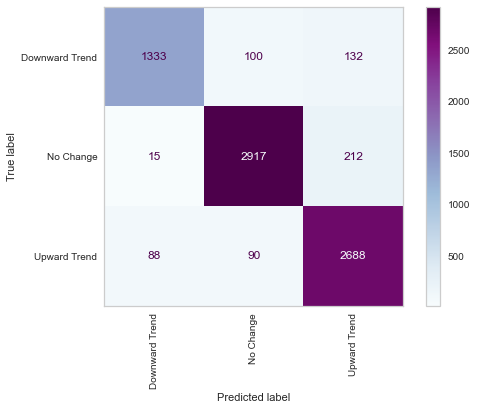

In [107]:
# Confusion Matrix - summary of the model's performance
wos_rf_cm_optimal = confusionMatrix(wos_rf_clf_pipe_optimal, X2_test, y2_test)

In [108]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(wos_rf_clf_pipe_optimal, X2_test, y2_test)

AUC score is: 0.991


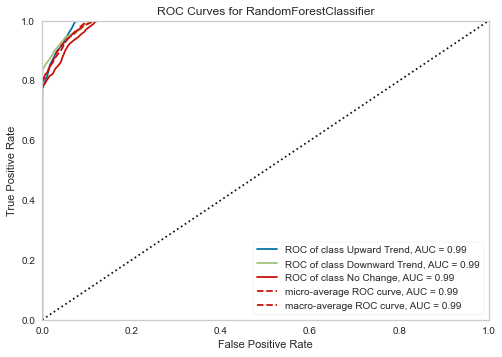

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder=['Downward Trend', 'No Change', 'Upward Trend'],
       estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('randomforestclassifier',
                                  RandomForestClassifier(max_depth=982,
                                                         n_estimators=435))]))

In [109]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
wos_rf_roc_optimal = plotROC(wos_rf_clf_pipe_optimal, X2_train, y2_train, X2_test, y2_test)
wos_rf_roc_optimal

## **Extreme Gradient Boosting (XGBoost) Classifier**
The Extreme Gradient Boosting (XGBoost) classifier is a boosting supervised learning algorithm based on the gradient boosted decision trees, which is computationally efficient and often produces improved accuracy (XGBoost, n.d.). This model works by having multiple trees that build on top of each other to correct the errors of previously trained trees; in which the misclassified labels are given higher weights (XGBoost, n.d.). 

To control overfitting the data (high training accuracy but low test accuracy), the following parameters can be adjusted: maximum depth of tree and minimum child weight (XGBoost, n.d.). 

Another parameter that can be adjusted is the learning rate, which can impact the computational speed of running the algorithm on how fast the model learns. Learning rate adjusts the weights on each step of the training, where lower learning rate tends to produce better results but makes running the algorithm slower.

### Base Model (default settings)

In [14]:
# Running with default settings (hyperparameter and parameter values)

# Pipeline created with feature scaler and ML model
wos_xgb_clf_pipe = make_pipeline(xgb_clf)

# Fitting the training data
wos_xgb_clf_pipe.fit(X2_train, y2_train)

# Running time of data fitting
%time wos_xgb_clf_pipe.fit(X2_train, y2_train)

# 5-fold cross validation of training data
# Divides data into 5 folds or equalish parts
# Trains each combination of 4
# Evalutes or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (wos_xgb_clf_pipe, X2_train, y2_train)

[17:14:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:14:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1.57 s
[17:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:14:34] WARNING: C:/Users/Administrator/worksp

In [111]:
# Using model to predict test set
pred_xgb_wos_model = wos_xgb_clf_pipe.predict(X2_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\txGBoost - Classification Report \n===========================================================')
classReport(y2_test, pred_xgb_wos_model)

	xGBoost - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.93      0.84      0.88      1565
     No Change       0.93      0.94      0.93      3144
  Upward Trend       0.89      0.93      0.91      2866

      accuracy                           0.92      7575
     macro avg       0.92      0.90      0.91      7575
  weighted avg       0.92      0.92      0.92      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


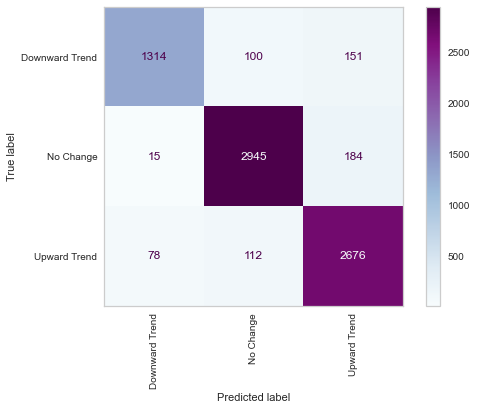

In [112]:
# Confusion Matrix - summary of the model's performance
wos_xgb_cm = confusionMatrix(wos_xgb_clf_pipe, X2_test, y2_test)

In [113]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(wos_xgb_clf_pipe, X2_test, y2_test)

AUC score is: 0.991


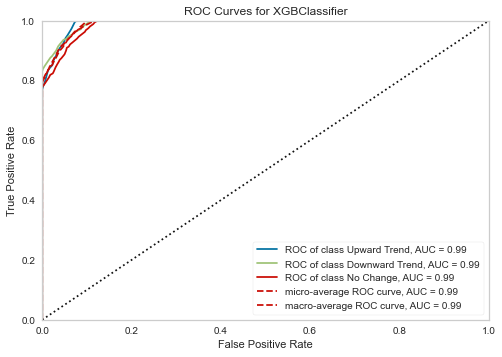

In [114]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
wos_xgb_roc = plotROC(wos_xgb_clf_pipe, X2_train, y2_train, X2_test, y2_test)

### Hyperparameter Tuning with HalvingRandomSearchCV
- Cross validation is performed during training (where cv = k-fold cross-validation)

In [115]:
# Find all parameters/hyperparameters of wos_xgb_clf_pipe model
wos_xgb_clf_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'xgbclassifier', 'xgbclassifier__objective', 'xgbclassifier__use_label_encoder', 'xgbclassifier__base_score', 'xgbclassifier__booster', 'xgbclassifier__colsample_bylevel', 'xgbclassifier__colsample_bynode', 'xgbclassifier__colsample_bytree', 'xgbclassifier__enable_categorical', 'xgbclassifier__gamma', 'xgbclassifier__gpu_id', 'xgbclassifier__importance_type', 'xgbclassifier__interaction_constraints', 'xgbclassifier__learning_rate', 'xgbclassifier__max_delta_step', 'xgbclassifier__max_depth', 'xgbclassifier__min_child_weight', 'xgbclassifier__missing', 'xgbclassifier__monotone_constraints', 'xgbclassifier__n_estimators', 'xgbclassifier__n_jobs', 'xgbclassifier__num_parallel_tree', 'xgbclassifier__predictor', 'xgbclassifier__random_state', 'xgbclassifier__reg_alpha', 'xgbclassifier__reg_lambda', 'xgbclassifier__scale_pos_weight', 'xgbclassifier__subsample', 'xgbclassifier__tree_method', 'xgbclassifier__validate_parameters', 'xgbclassifier__verbosi

In [116]:
# Using 5-fold cross validation
wos_xgb_clf_grid = HalvingRandomSearchCV(estimator = wos_xgb_clf_pipe, param_distributions = xgb_parameters, n_jobs = -1, cv = 5, verbose = 2, scoring = f1,
                                        random_state=random_num)

# Note: Using the same XGBoost parameters from predicting with sentiment variables in Part 1

In [117]:
# Half an hour to run!
# Conducting Random Search
%time wos_xgb_clf_grid.fit(X2_train,y2_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 30
max_resources_: 22723
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 757
n_resources: 30
Fitting 5 folds for each of 757 candidates, totalling 3785 fits
----------
iter: 1
n_candidates: 253
n_resources: 90
Fitting 5 folds for each of 253 candidates, totalling 1265 fits
----------
iter: 2
n_candidates: 85
n_resources: 270
Fitting 5 folds for each of 85 candidates, totalling 425 fits
----------
iter: 3
n_candidates: 29
n_resources: 810
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 2430
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 5
n_candidates: 4
n_resources: 7290
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 6
n_candidates: 2
n_resources: 21870
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[09:11:19] WARNING: C:/Users/Administrator/work

HalvingRandomSearchCV(estimator=Pipeline(steps=[('xgbclassifier',
                                                 XGBClassifier(base_score=0.5,
                                                               booster='gbtree',
                                                               colsample_bylevel=1,
                                                               colsample_bynode=1,
                                                               colsample_bytree=1,
                                                               enable_categorical=False,
                                                               gamma=0,
                                                               gpu_id=-1,
                                                               importance_type=None,
                                                               interaction_constraints='',
                                                               learning_rate=0.300000012,
                       

In [118]:
# Returns the best combination from the list of combinations that were randomly checked
wos_xgb_best_parameters = wos_xgb_clf_grid.best_estimator_.get_params()
for param_name in sorted(xgb_parameters.keys()):
    print('\t Optimal %s: %r' % (param_name, wos_xgb_best_parameters[param_name]))

	 Optimal xgbclassifier__learning_rate: 0.5502
	 Optimal xgbclassifier__max_depth: 5
	 Optimal xgbclassifier__min_child_weight: 1
	 Optimal xgbclassifier__n_estimators: 170


In [119]:
# Looking for the best model results 
wos_xgb_results = pd.DataFrame(wos_xgb_clf_grid.cv_results_)
wos_xgb_results.sort_values('rank_test_score')

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__n_estimators,param_xgbclassifier__min_child_weight,param_xgbclassifier__max_depth,param_xgbclassifier__learning_rate,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1139,6,21870,20.261218,2.190282,0.071361,0.027683,750,1,5,0.2013,...,0.907826,0.005757,1,0.910978,0.909962,0.911911,0.911929,0.913444,0.911645,0.001155
1138,6,21870,7.029284,0.319639,0.034883,0.019561,170,1,5,0.5502,...,0.907826,0.005757,1,0.910978,0.909962,0.911911,0.911929,0.913444,0.911645,0.001155
1137,5,7290,9.554437,0.168131,0.041860,0.019037,750,1,5,0.2013,...,0.903209,0.012314,3,0.911443,0.911740,0.916057,0.913008,0.910024,0.912454,0.002036
1136,5,7290,3.830187,0.600893,0.012757,0.005136,170,1,5,0.5502,...,0.903209,0.012314,3,0.911443,0.911740,0.916057,0.913008,0.910024,0.912454,0.002036
1134,5,7290,14.683478,0.378554,0.085714,0.037889,940,1,4,0.3199,...,0.903209,0.012314,3,0.911443,0.911740,0.916057,0.913008,0.910024,0.912454,0.002036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,0,30,0.890820,0.110234,0.004784,0.000399,330,13,3,0.9358,...,0.082540,0.041876,795,0.098765,0.098765,0.076923,0.114943,0.150538,0.107987,0.024470
486,0,30,0.564113,0.031143,0.004985,0.000631,240,19,2,1.9229,...,0.082540,0.041876,795,0.098765,0.098765,0.076923,0.114943,0.150538,0.107987,0.024470
487,0,30,1.777852,0.086294,0.006581,0.002237,670,13,4,1.0237,...,0.082540,0.041876,795,0.098765,0.098765,0.076923,0.114943,0.150538,0.107987,0.024470
474,0,30,0.210894,0.003189,0.004585,0.000489,90,11,2,1.3574,...,0.082540,0.041876,795,0.098765,0.098765,0.076923,0.114943,0.150538,0.107987,0.024470


In [15]:
# Running model with the optimal combination from hyperparameter tuning
xgb_clf3 = XGBClassifier(learning_rate=0.5502, max_depth = 5, min_child_weight = 1, n_estimators=170)

# Pipeline created with feature scaler and ML model
wos_xgb_clf_pipe_optimal = make_pipeline(scaler, xgb_clf3)

# Fitting the training data
wos_xgb_clf_pipe_optimal.fit(X2_train, y2_train)
%time wos_xgb_clf_pipe_optimal.fit(X2_train, y2_train)

# Evaluates or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (wos_xgb_clf_pipe_optimal, X2_train, y2_train)

[17:14:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:14:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2.29 s
[17:14:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:00] WARNING: C:/Users/Administrator/worksp

In [121]:
# Using model to predict test set
pred_xgb_wos_model_optimal = wos_xgb_clf_pipe_optimal.predict(X2_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\txGBoost Classifier - Classification Report \n===========================================================')
classReport(y2_test, pred_xgb_wos_model_optimal)

	xGBoost Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.93      0.84      0.88      1565
     No Change       0.94      0.93      0.93      3144
  Upward Trend       0.88      0.94      0.91      2866

      accuracy                           0.91      7575
     macro avg       0.92      0.90      0.91      7575
  weighted avg       0.92      0.91      0.91      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


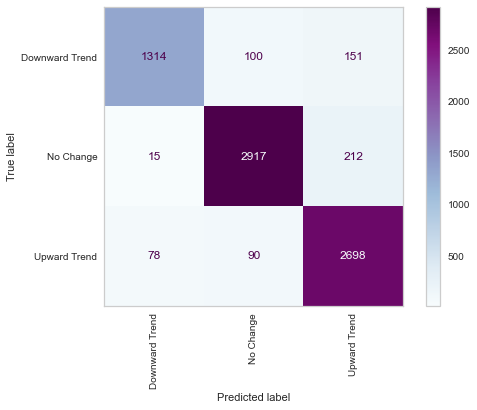

In [122]:
# Confusion Matrix - summary of the model's performance
wos_xgb_cm_optimal = confusionMatrix(wos_xgb_clf_pipe_optimal, X2_test, y2_test)

In [123]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(wos_xgb_clf_pipe_optimal, X2_test, y2_test)

AUC score is: 0.991


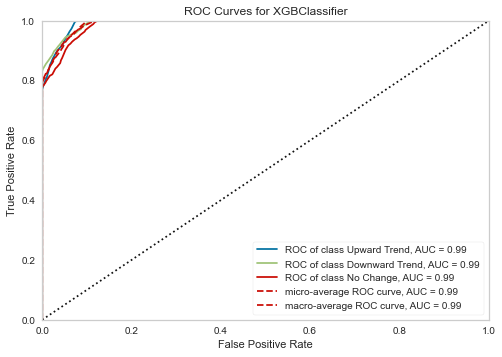

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder=['Downward Trend', 'No Change', 'Upward Trend'],
       estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('xgbclassifier',
                                  XGBClassifier(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=...
                                                interaction_constraints='',
                                                learning_rate=0.5502,
                                                max_delta_step=0, max_depth=5,
                                                min_child_weight=1, missing=nan,
                                            

In [124]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
wos_xgb_roc_optimal = plotROC(wos_xgb_clf_pipe_optimal, X2_train, y2_train, X2_test, y2_test)
wos_xgb_roc_optimal

## **Support Vector Classifier (SVC)**
Support vector machine is a distance-based supervised learning model that plots each data as a point in n-dimensional space in which one or more hyperplanes in hyperspace are constructed and find the optimal way to separate these points, the three data labels (widest separation means larger margin and lower classification error). However, lower classification error on training data does not always translate into lower misclassification on the testing data (and newer data points). In addition, support vector classifiers account for outliers through the regularization parameter, C, which penalizes misclassifications in the margin by a factor of C > 0. This means that the model must allow misclassification so that the model is not sensitive to outliers.

### Base Model (default settings)

In [16]:
# Running with default settings (hyperparameter and parameter values)

# Pipeline created with feature scaler and ML model
wos_svc_clf_pipe = make_pipeline(scaler, svc_clf)

# Fitting the training data
wos_svc_clf_pipe.fit(X2_train, y2_train)

# Running time of data fitting
%time wos_svc_clf_pipe.fit(X2_train, y2_train)

# 5-fold cross validation of training data
# Divides data into 5 folds or equalish parts
# Trains each combination of 4
# Evalutes or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (wos_svc_clf_pipe, X2_train, y2_train)

Wall time: 2min 41s
Mean Accuracy of 5-fold cross validation: 0.523
Accuracies of 5-fold cross validation:  [0.529 0.515 0.518 0.521 0.53 ]
Wall time: 8min 58s


In [126]:
# Using model to predict test set
pred_svc_wos_model = wos_svc_clf_pipe.predict(X2_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\Support Vector Classifier - Classification Report \n===========================================================')
classReport(y2_test, pred_svc_wos_model)

\Support Vector Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.74      0.10      0.17      1565
     No Change       0.50      0.88      0.64      3144
  Upward Trend       0.58      0.36      0.45      2866

      accuracy                           0.52      7575
     macro avg       0.61      0.45      0.42      7575
  weighted avg       0.58      0.52      0.47      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


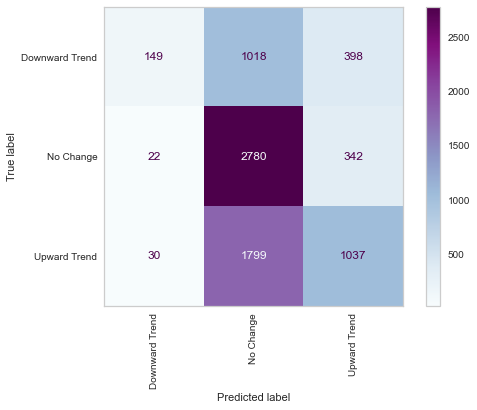

In [127]:
# Confusion Matrix - summary of the model's performance
wos_svc_cm = confusionMatrix(wos_svc_clf_pipe, X2_test, y2_test)

In [128]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(wos_svc_clf_pipe, X2_test, y2_test)

# Since default probability=False, this default setting was changed to True 
# (even though requires a lot of computational power).

AUC score is: 0.629


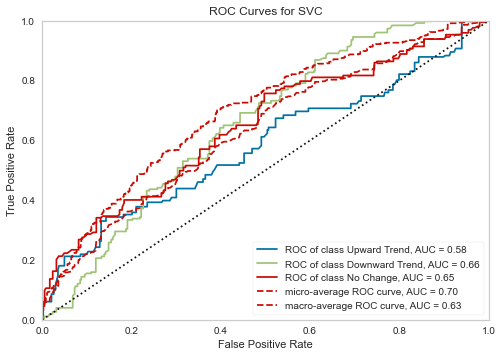

In [129]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
wos_svc_roc = plotROC(wos_svc_clf_pipe, X2_train, y2_train, X2_test, y2_test)

### Hyperparameter Tuning with HalvingRandomSearchCV
- Cross validation is performed during training (where cv = k-fold cross-validation)

In [130]:
# Find all parameters/hyperparameters of wos_svc_clf_pipe model
wos_svc_clf_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'svc', 'minmaxscaler__clip', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [131]:
# takes ~1 hour!
# using 5-fold cross validation
wos_svc_clf_grid = HalvingRandomSearchCV(estimator = wos_svc_clf_pipe, param_distributions = svc_parameters, n_jobs = -1, cv = 5, verbose = 2, scoring = f1,
                                    random_state=random_num)

# Note: Using the same XGBoost parameters from predicting with sentiment variables in Part 1

In [132]:
# Conducting Random Search
%time wos_svc_clf_grid.fit(X2_train,y2_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 7
min_resources_: 30
max_resources_: 22723
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 30
Fitting 5 folds for each of 100 candidates, totalling 500 fits
----------
iter: 1
n_candidates: 34
n_resources: 90
Fitting 5 folds for each of 34 candidates, totalling 170 fits
----------
iter: 2
n_candidates: 12
n_resources: 270
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 4
n_resources: 810
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 2430
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 1h 11min 19s


HalvingRandomSearchCV(estimator=Pipeline(steps=[('minmaxscaler',
                                                 MinMaxScaler()),
                                                ('svc',
                                                 SVC(probability=True))]),
                      n_jobs=-1,
                      param_distributions={'svc__C': [0.0001, 0.001, 0.01, 0.1,
                                                      1, 10, 50, 100, 500,
                                                      1000],
                                           'svc__gamma': [0.0001, 0.001, 0.01,
                                                          0.1, 1, 50, 10, 100,
                                                          500, 1000]},
                      random_state=123,
                      scoring=make_scorer(f1_score, average=macro), verbose=2)

In [133]:
# Returns the best combination from the list of combinations that were randomly checked
wos_svc_best_parameters = wos_svc_clf_grid.best_estimator_.get_params()
for param_name in sorted(svc_parameters.keys()):
    print('\t Optimal %s: %r' % (param_name, wos_svc_best_parameters[param_name]))

	 Optimal svc__C: 1000
	 Optimal svc__gamma: 1000


In [134]:
# Looking for the best model results 
wos_svc_results = pd.DataFrame(wos_svc_clf_grid.cv_results_)
wos_svc_results.sort_values('rank_test_score')

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__gamma,param_svc__C,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
151,4,2430,17.352566,2.765971e+00,0.078921,2.142707e-02,1000,1000,"{'svc__gamma': 1000, 'svc__C': 1000}",0.583148,...,0.568870,0.023497,1,0.602350,0.582294,0.587771,0.607080,0.636685,0.603236,0.019037
150,4,2430,11.008970,1.141038e+00,0.131161,1.320129e-02,1000,500,"{'svc__gamma': 1000, 'svc__C': 500}",0.577664,...,0.564406,0.021128,2,0.600042,0.586910,0.582627,0.602428,0.626392,0.599680,0.015330
149,3,810,1.617404,4.516397e-01,0.008371,2.997278e-03,1000,1000,"{'svc__gamma': 1000, 'svc__C': 1000}",0.594445,...,0.552262,0.036371,3,0.651118,0.613018,0.624235,0.640970,0.652924,0.636453,0.015526
136,2,270,0.150297,1.859678e-02,0.002392,4.882662e-04,1000,1000,"{'svc__gamma': 1000, 'svc__C': 1000}",0.599023,...,0.543279,0.040368,4,0.720316,0.727996,0.754495,0.742446,0.695049,0.728060,0.020275
148,3,810,1.149953,2.241180e-01,0.011761,2.983522e-03,1000,500,"{'svc__gamma': 1000, 'svc__C': 500}",0.594445,...,0.539136,0.043412,5,0.651118,0.600936,0.621450,0.620426,0.635704,0.625927,0.016763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,0,30,0.001395,4.883830e-04,0.000598,4.881883e-04,100,0.01,"{'svc__gamma': 100, 'svc__C': 0.01}",0.333333,...,0.231746,0.052740,100,0.215686,0.202020,0.215686,0.196078,0.196078,0.205110,0.008904
26,0,30,0.001994,1.544156e-03,0.000797,3.984454e-04,10,0.01,"{'svc__gamma': 10, 'svc__C': 0.01}",0.333333,...,0.231746,0.052740,100,0.215686,0.202020,0.215686,0.196078,0.196078,0.205110,0.008904
25,0,30,0.001595,7.975103e-04,0.000997,1.784161e-07,50,0.01,"{'svc__gamma': 50, 'svc__C': 0.01}",0.333333,...,0.231746,0.052740,100,0.215686,0.202020,0.215686,0.196078,0.196078,0.205110,0.008904
36,0,30,0.001395,4.879158e-04,0.000797,3.986836e-04,10,0.1,"{'svc__gamma': 10, 'svc__C': 0.1}",0.333333,...,0.231746,0.052740,100,0.215686,0.202020,0.215686,0.196078,0.196078,0.205110,0.008904


In [9]:
# ~8mins to run
# Running model with the optimal combination from hyperparameter tuning
svc_clf3 = SVC(probability=True, C = 1000, gamma = 1000)

# Pipeline created with feature scaler and ML model
wos_svc_clf_pipe_optimal = make_pipeline(scaler, svc_clf3)

# Fitting the training data
#wos_svc_clf_pipe_optimal.fit(X2_train, y2_train)
%time wos_svc_clf_pipe_optimal.fit(X2_train, y2_train)

# Evaluates or gives back accuracy of estimator on the 5th fold of the training dataset
%time crossValidation (wos_svc_clf_pipe_optimal, X2_train, y2_train)

Wall time: 53min 3s
Mean Accuracy of 5-fold cross validation: 0.649
Accuracies of 5-fold cross validation:  [0.657 0.626 0.65  0.663 0.648]
Wall time: 2h 31min 33s


In [10]:
# Using model to predict test set
pred_svc_wos_model_optimal = wos_svc_clf_pipe_optimal.predict(X2_test)

# Show accuracy, precision, recall, F1 Score of the test set
print('\tSupport Vector Classifier - Classification Report \n===========================================================')
classReport(y2_test, pred_svc_wos_model_optimal)

	Support Vector Classifier - Classification Report 
                precision    recall  f1-score   support

Downward Trend       0.61      0.53      0.57      1565
     No Change       0.66      0.73      0.69      3144
  Upward Trend       0.66      0.62      0.64      2866

      accuracy                           0.65      7575
     macro avg       0.64      0.63      0.63      7575
  weighted avg       0.65      0.65      0.65      7575



C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


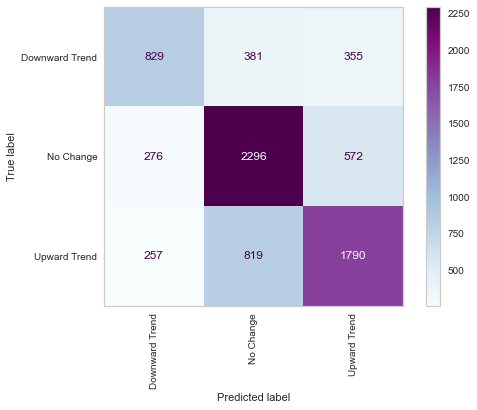

In [11]:
# Confusion Matrix - summary of the model's performance
wos_svc_cm_optimal = confusionMatrix(wos_svc_clf_pipe_optimal, X2_test, y2_test)

In [12]:
# Area under the Curve (AUC) Score
# One vs. Rest (OVR)
getAUCscore(wos_svc_clf_pipe_optimal, X2_test, y2_test)

AUC score is: 0.780


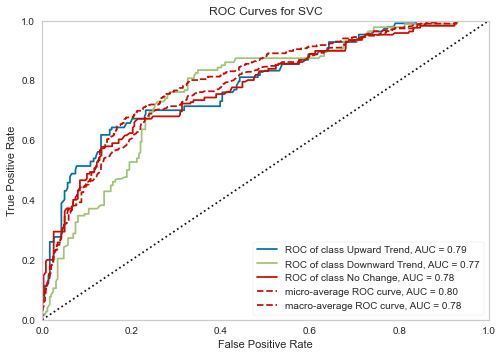

In [13]:
# ROC curves of the three classes with the macro and micro averages
# Measures how well can the model classify the different labels
wos_svc_roc_optimal = plotROC(wos_svc_clf_pipe_optimal, X2_train, y2_train, X2_test, y2_test)